## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import pickle
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
# import torch_xla
# import torch_xla.core.xla_model as xm

!pip install torchviz
from torchviz import make_dot

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=a8e4127d399c9d3f63627bdb0d41f5c641298d98b8c09b8d612cc9f2bb47f189
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


## Preprocessing



### Extract Labels and Binning Them

We only need the InstanceID (nodule id) and the Spiculation rating (label)

In [ ]:
if os.path.isfile(os.path.join('/content/drive/MyDrive/Colab Notebooks/Siamese Network/Datasets','dataset.pickle')):
  df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Research/parsedXMLnew.xlsx')
  df = df[['InstanceID', 'spiculation']]
  df.head()

Load the images and match their corresponding labels.

In [ ]:
ds = []
if os.path.isfile(os.path.join('/content/drive/MyDrive/Colab Notebooks/Siamese Network/Datasets','dataset.pickle')):
  with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/Siamese Network/Datasets','dataset.pickle'), 'rb') as f:
    ds = pickle.load(f)
else:
  !tar xzf '/content/drive/MyDrive/Colab Notebooks/Research/LIDC/nodules.tar.gz'

  file_names = glob(os.path.join('/content/nodules','*.png'))
  id_set = set(df['InstanceID'])
  for f in file_names:
    id = int(f.split('/')[-1].split('.')[0])
    # print('InstanceID:', id, end='\n\n')
    if id in id_set:
      label =  df[df['InstanceID']==id]['spiculation'].iloc[0]
      img = cv2.imread(f, 0)
      ds.append([img.astype(np.float32), label, id])

  with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/Siamese Network/Datasets','dataset.pickle'), 'wb') as f:
    pickle.dump(ds, f)

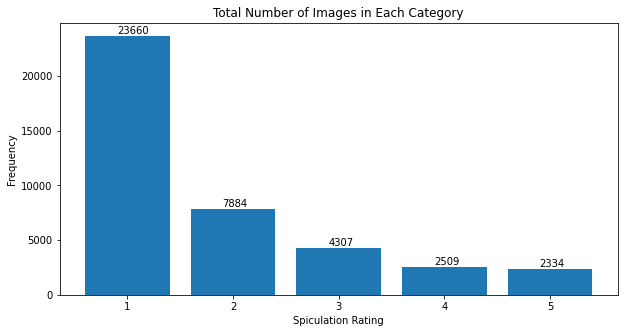

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Total Number of Images in Each Category')
labels, counts = np.unique([d[1] for d in ds], return_counts='True')
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Frequency')
plt.xlabel('Spiculation Rating')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + 200, yval)
plt.show()

### Scaling Images


In [ ]:
temp = []
input_size = (64,64,1)
min_size = (12,12)

for d in ds:
  if d[0].shape >= min_size:
    if d[0].shape < input_size[:2]:
      # Up-Scaling
      d[0] = cv2.resize(d[0], dsize=input_size[:2], interpolation=cv2.INTER_CUBIC)
    elif d[0].shape > input_size:
      # Down-Scaling
      d[0] = cv2.resize(d[0], dsize=input_size[:2], interpolation=cv2.INTER_AREA)
    temp.append(d)

del(ds)
ds = temp

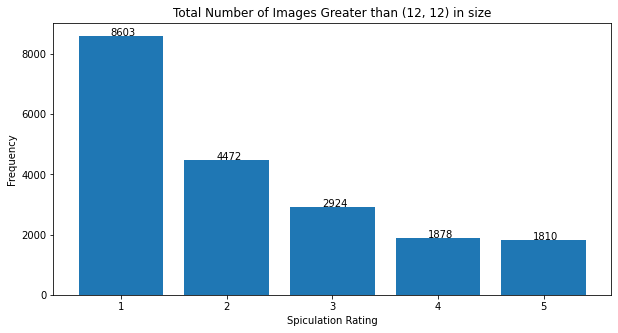

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title(f'Total Number of Images Greater than {min_size} in size')
labels, counts = np.unique([d[1] for d in ds], return_counts='True')
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Frequency')
plt.xlabel('Spiculation Rating')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + 10, yval)
plt.show()

In [ ]:
images, labels, nodule_ids = [], [], []
for d in ds:
  images.append(d[0])
  labels.append(d[1])
  nodule_ids.append(d[2])
images = np.array(images)
labels = np.array(labels)
nodule_ids = np.array(nodule_ids)

### Create Lung Nodule Dataset Class

In [ ]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
      return torch.from_numpy(sample)   
class LungNoduleDataset(Dataset):
  """ Required Methods """
  def __init__(self, images, labels, nodule_ids, transform):
    self.labels = labels
    self.images = images
    self.nodule_ids = nodule_ids
    self.transform = transform

    self.rand_samp = False
  def __len__(self):
    return len(self.labels)
  def __getitem__(self, idx):
    return self.transform(self.images[idx]), self.labels[idx]

  """ Custom Methods """
  def get_image_from_id(self, id):
    """ Returns image and label using Nodule ID """
    idx = np.where(self.nodule_ids == id)[0][0]
    return self.__getitem__(idx)

  def split_to_classes(self):
    """ Organizes data into respective classes """
    if os.path.isfile(os.path.join('/content/drive/MyDrive/Colab Notebooks/Siamese Network/Datasets','classes.pickle')):
      with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/Siamese Network/Datasets','classes.pickle'), 'rb') as f:
        self.classes = pickle.load(f)
    else:
      self.classes = {1: [], 2: [], 3: [], 4: [], 5: []}
      for image,label,id in zip(self.images, self.labels, self.nodule_ids):
        self.classes[label].append((image, id))
      with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/Siamese Network/Datasets','classes.pickle'), 'wb') as f:
          pickle.dump(self.classes, f)

  def bin_classes(self):
    """ Balance and bin classes by randomly sampling from each class 
        until the minimum size is met for each class. """
    self.bins = {1: [], 2: [], 3: [], 4: [], 5: []}
    self.min_bin_size = 50
    for k in self.classes.keys():
      used = set()
      while len(self.bins[k]) != self.min_bin_size:
        idx = np.random.randint(low=0, high=len(self.classes[k]))
        if idx not in used:
          self.bins[k].append((self.classes[k])[idx])
          used.add(idx)

  def random_sampling(self):
    self.split_to_classes()
    self.bin_classes()
    self.rand_samp = True

  def get_bins(self):
    if self.rand_samp:
      return self.bins
    else:
      print('Have not randomly sample classes. Need to run random_sampling() method.')

In [ ]:
ds = LungNoduleDataset(images, labels, nodule_ids, ToTensor())

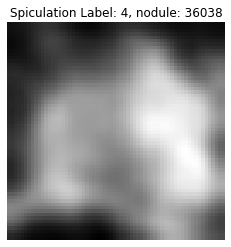

In [ ]:
plt.imshow(ds[100][0],cmap='gray')
plt.title(f'Spiculation Label: {ds[100][1]}, nodule: {nodule_ids[100]}')
plt.axis('off')
plt.show()

### Random Sampling

In [ ]:
ds.random_sampling()

In [ ]:
counts = [len(b) for b in ds.get_bins().values()]

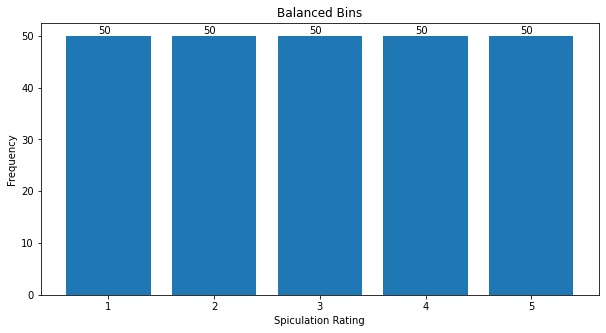

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title(f'Balanced Bins')
# labels, counts = np.unique([len(b) for b in ds.get_bins().values()], return_counts='True')
bars = plt.bar(range(1,6), counts, align='center')
plt.gca().set_xticks(range(1,6))
plt.ylabel('Frequency')
plt.xlabel('Spiculation Rating')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + .5, yval)
plt.show()

### Pair Images

In [ ]:
class Pairs(Dataset):
  """ Required Methods """
  def __init__(self, bins, transform):
    """ Pair images by spiculation rating """
    self.labels = []
    self.pairs = []
    self.transform = transform

    labels = []
    samples = []
    for label, bin in bins.items():
      for sample in bin:
        samples.append(sample)
        labels.append(label)

    used = set()
    for sample_a,label_a in zip(samples, labels):
      for sample_b,label_b in zip(samples, labels):
        if label_a == label_b:
          """ positive pair """
          self.pairs.append(np.array([sample_a[0], sample_b[0]]))
          self.labels.append(1)
        else:
          """ negative pair """
          tup = tuple(sorted((sample_a[1], sample_b[1])))
          if tup not in used:
            self.pairs.append(np.array([sample_a[0], sample_b[0]]))
            self.labels.append(0)
            used.add(tup)



  def __len__(self):
    return len(self.labels)
  def __getitem__(self, idx):
    pair = self.transform(self.pairs[idx])
    return pair[0][None,...], pair[1][None,...], self.labels[idx]

  """ Custom Methods """
  def get_labels_and_counts(self):
    return np.unique(self.labels, return_counts='True')     

In [ ]:
pairs = Pairs(ds.get_bins(), ToTensor())

In [ ]:
tp = [(1,2), (2,1)]
s = set()
for t in tp:
  print(t)
  s.add(tuple(sorted(t)))
s

(1, 2)
(2, 1)


{(1, 2)}

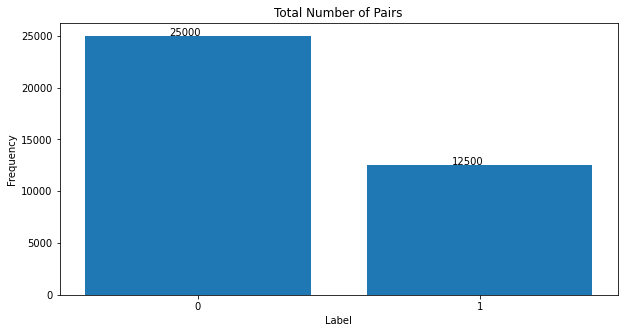

In [ ]:
afig = plt.figure(figsize=(10,5))
plt.title(f'Total Number of Pairs')
labels, counts = pairs.get_labels_and_counts()
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Frequency')
plt.xlabel('Label')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + 10, yval)
plt.show()

## SCNN

In [ ]:
class SCNN(nn.Module):
  def __init__(self):
    super(SCNN, self).__init__()
    self.cnnl = nn.Sequential (
        # First Conv Pool 
        nn.Conv2d(1, 32, 3, padding='same'),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        # Second Conv Pool
        nn.Conv2d(32, 64, 3, padding='same'),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        # Second Conv Pool
        nn.Conv2d(64, 128, 3, padding='same'),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
    )

    self.fcl = nn.Sequential(
        # Dense Layers
        nn.Linear(8 * 8 * 64, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(128, 5),
        # nn.Sigmoid(),
        nn.Softmax(),
    ) 
  def forward_once(self, x):
    x = self.cnnl(x)
    x = x.view(-1,8 * 8 * 64)
    output = self.fcl(x)
    return output

  def forward(self, input_a, input_b):
    output1 = self.forward_once(input_a)
    output2 = self.forward_once(input_b)
    return output1, output2

In [ ]:
""" Loss Functions """
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=2.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, output1, output2, label):
    euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
    loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    return loss
class QuadrupletLoss(torch.nn.Module):
  def __init__(self, margin_1=2.0, margin_2=1.0):
    super(QuadrupletLoss, self).__init__()
    self.margin_1 = margin_1
    self.margin_2 = margin_2

  def forward(self, anchor, positive, negative_1, negative_2):
    euclidean_distance_pos = F.pairwise_distance(anchor, positive, keepdim=True)
    euclidean_distance_neg = F.pairwise_distance(anchor, negative_1, keepdim=True)
    euclidean_distance_neg_b = F.pairwise_distance(negative_1, negative_2, keepdim=True)

    quadruplet_loss = \
        F.relu(self.margin_1 + euclidean_distance_pos - euclidean_distance_neg) \
        + F.relu(self.margin_2 + euclidean_distance_pos - euclidean_distance_neg_b)

    return quadruplet_loss.mean()

NameError: ignored

## Training

### Split Dataset into Training, Validation, and Test Sets


In [ ]:
""" Split Pairs Dataset Into Training, Validation, and Testing Sets """
train_test_split = .2
ds_size = len(pairs)

test_size = int(np.floor(train_test_split * ds_size))

train_val_split = .2
train_size = ds_size - test_size

val_size = int(np.floor(train_test_split * train_size))

train_size = ds_size - test_size - val_size

In [ ]:
seed = torch.Generator()
seed.manual_seed(1)
training_data, val_data, test_data = random_split(pairs, [train_size, val_size, test_size], seed)

In [ ]:
model = SCNN().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Dataloaders

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
a, b, l = next(iter(train_dataloader))
a, b, l = a[0, None,...].cuda(), b[0,None,...].cuda(), l[0].cuda()
print(a.size(),b.size())
make_dot(model(a,b), params=dict(list(model.named_parameters()))).render("SCNN_torchviz", format="png")

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


'SCNN_torchviz.png'

In [ ]:
def show_plot(epochs,loss):
  fig, ax1 = plt.subplots(1,1, figsize=(12,12))
    
  ax1.plot(range(epochs), loss['training'], 'tab:blue')
  ax1.plot(range(epochs), loss['validation'], 'tab:orange')
  ax1.set_title('Training Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_yticks(np.arange(0,1.1,.1))

  # ax2.plot(range(epochs), loss['validation'])
  # ax2.set_title('Validation Loss')
  # ax2.set_xlabel('Epochs')
  # ax2.set_ylabel('Loss')
  # ax2.set_yticks(np.arange(0,1.1,.1))
  plt.show()

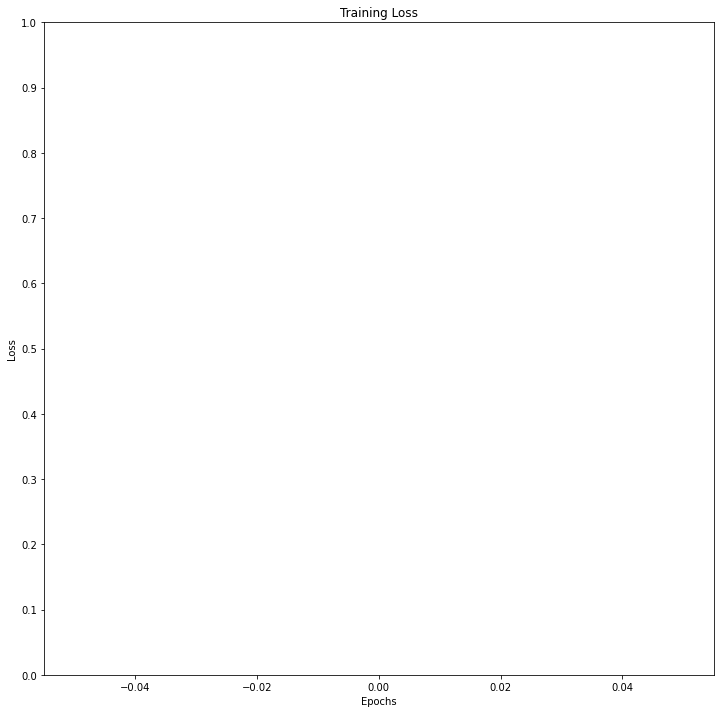

Epoch 1 		 Training Loss: 0.13691016642252604 		 Validation Loss: 0.715356725327512
Validation Loss Decreased(inf--->67.243532) 	 Saving The Model


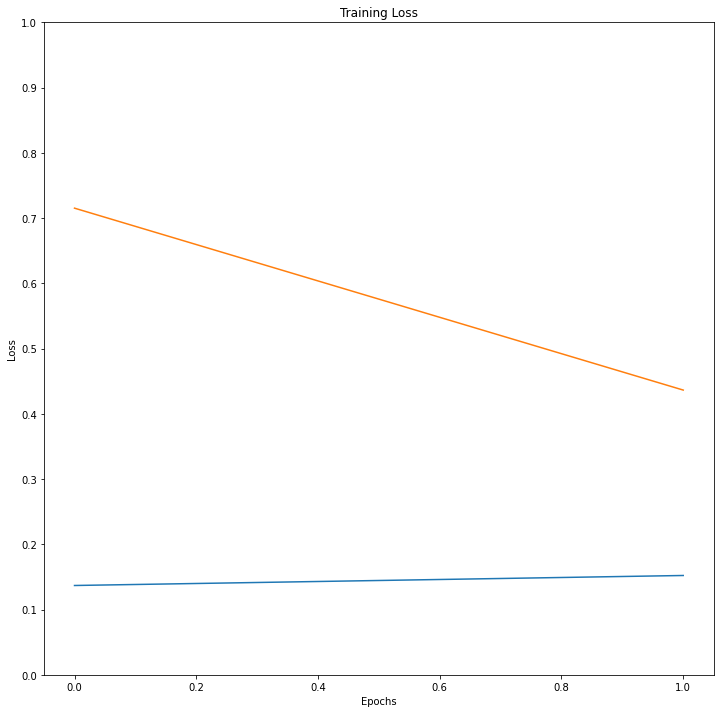

Epoch 2 		 Training Loss: 0.1522450968424479 		 Validation Loss: 0.4364769610952824
Validation Loss Decreased(67.243532--->41.028834) 	 Saving The Model


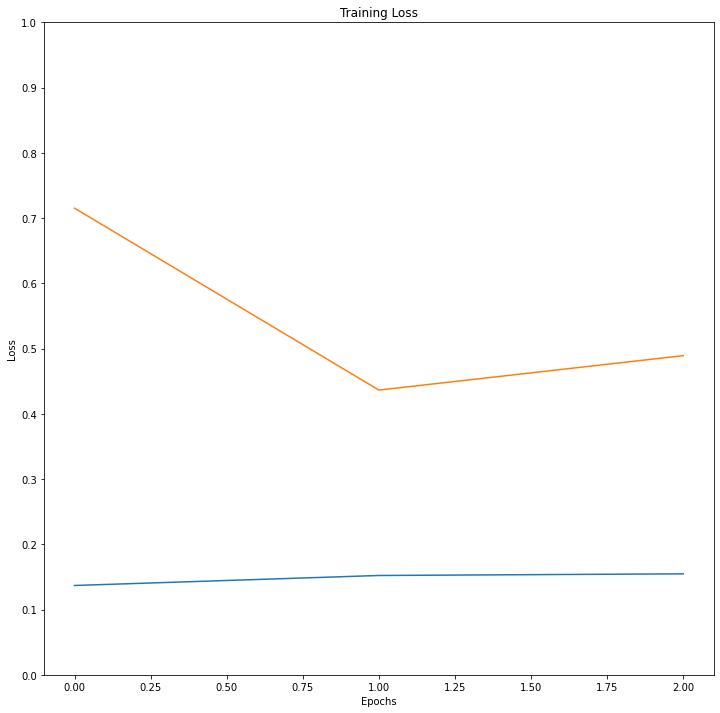

Epoch 3 		 Training Loss: 0.1547813924153646 		 Validation Loss: 0.4892496555409533


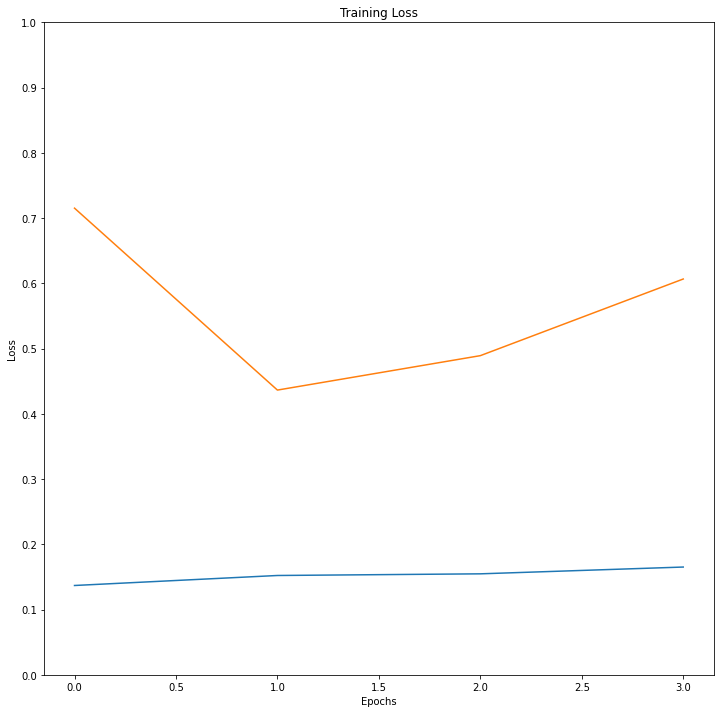

Epoch 4 		 Training Loss: 0.16519346110026042 		 Validation Loss: 0.6067500418805062


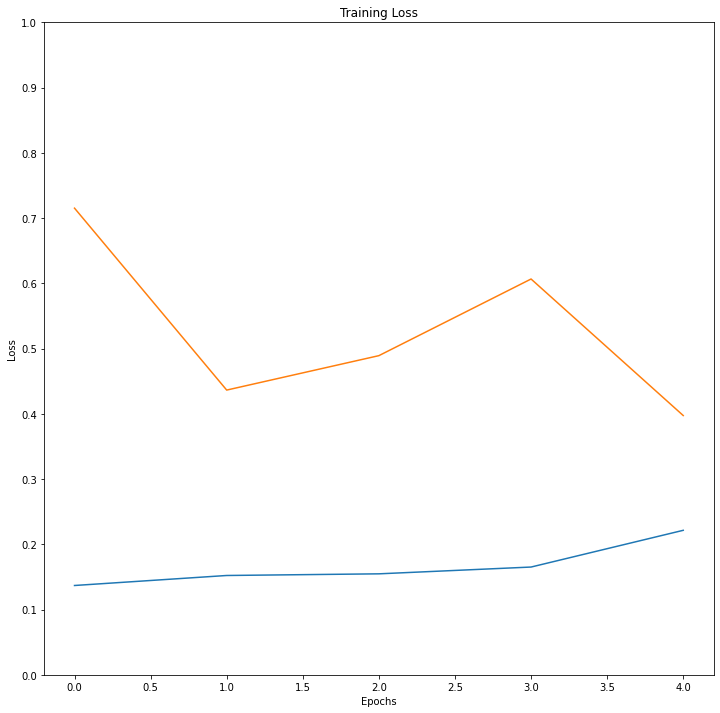

Epoch 5 		 Training Loss: 0.22150069173177084 		 Validation Loss: 0.39744232055988715
Validation Loss Decreased(41.028834--->37.359578) 	 Saving The Model


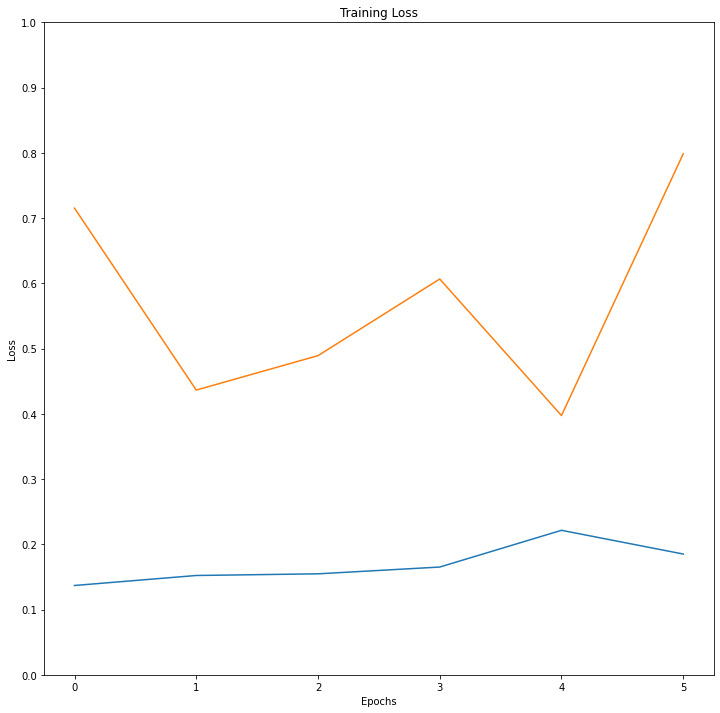

Epoch 6 		 Training Loss: 0.18512109375 		 Validation Loss: 0.7987086722191344


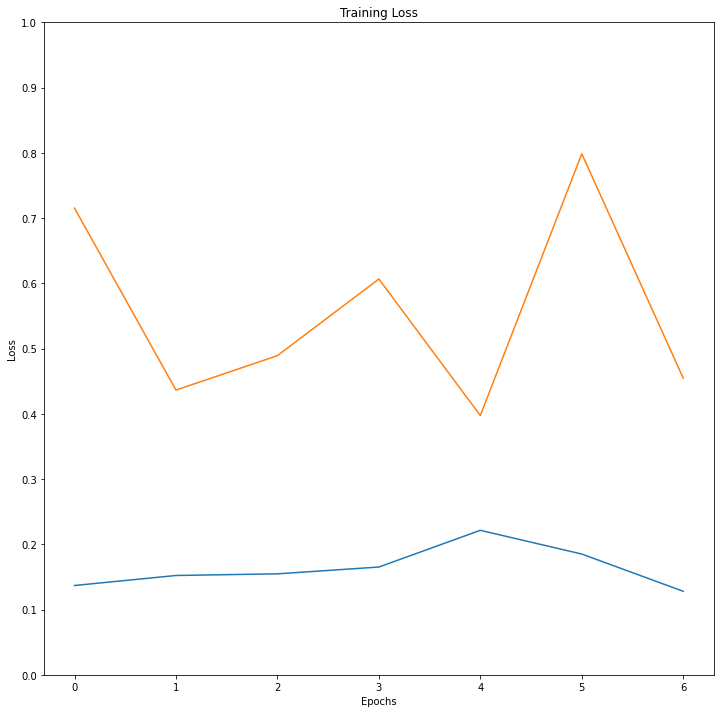

Epoch 7 		 Training Loss: 0.1280220947265625 		 Validation Loss: 0.45474395346134266


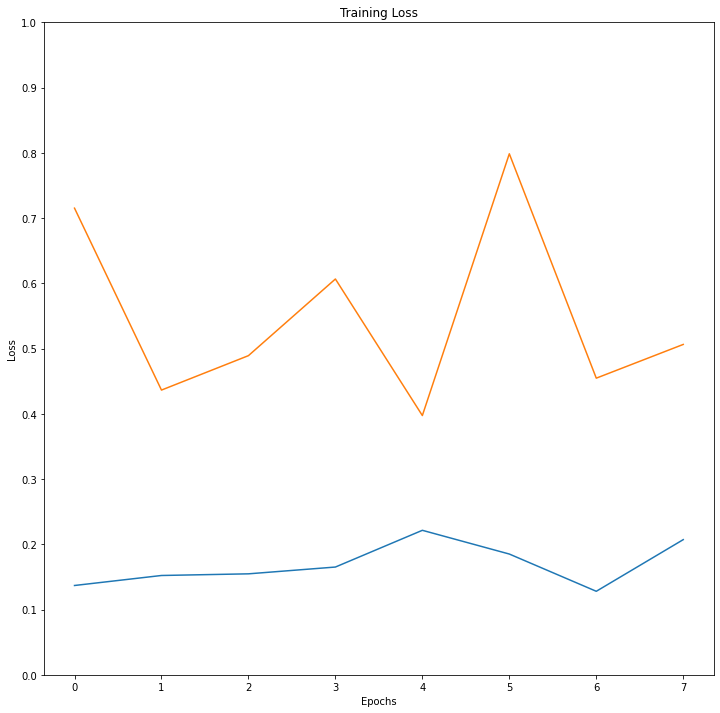

Epoch 8 		 Training Loss: 0.20720098876953125 		 Validation Loss: 0.5064539300634506


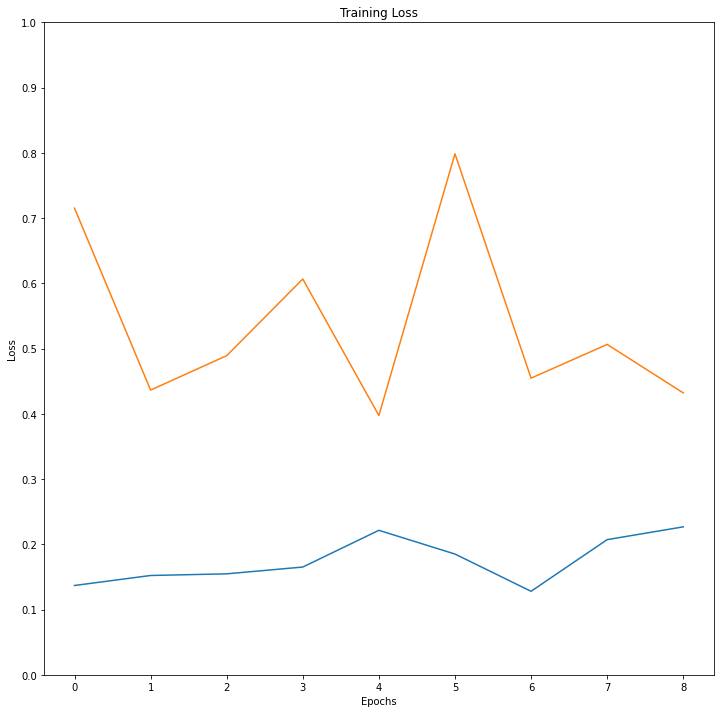

Epoch 9 		 Training Loss: 0.22679239908854168 		 Validation Loss: 0.43215425978315636


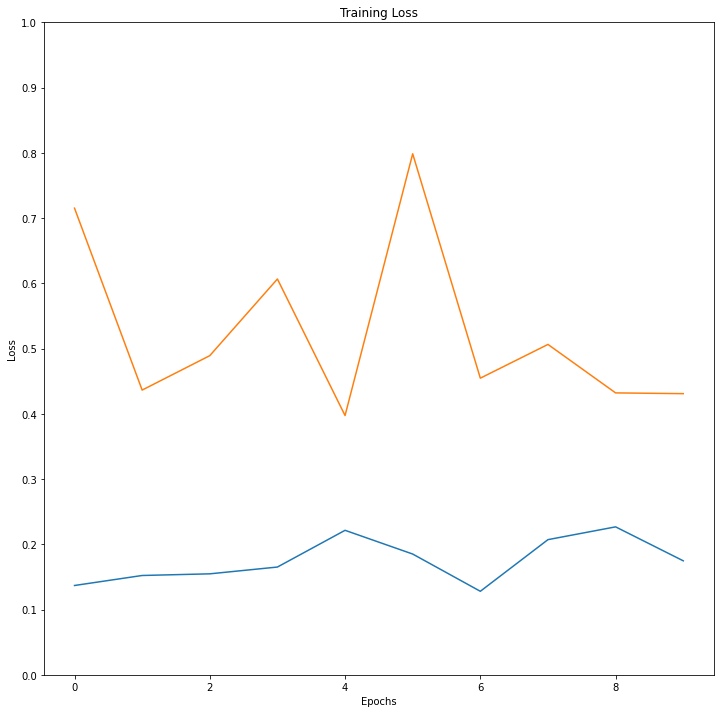

Epoch 10 		 Training Loss: 0.1747410888671875 		 Validation Loss: 0.43098976256999566


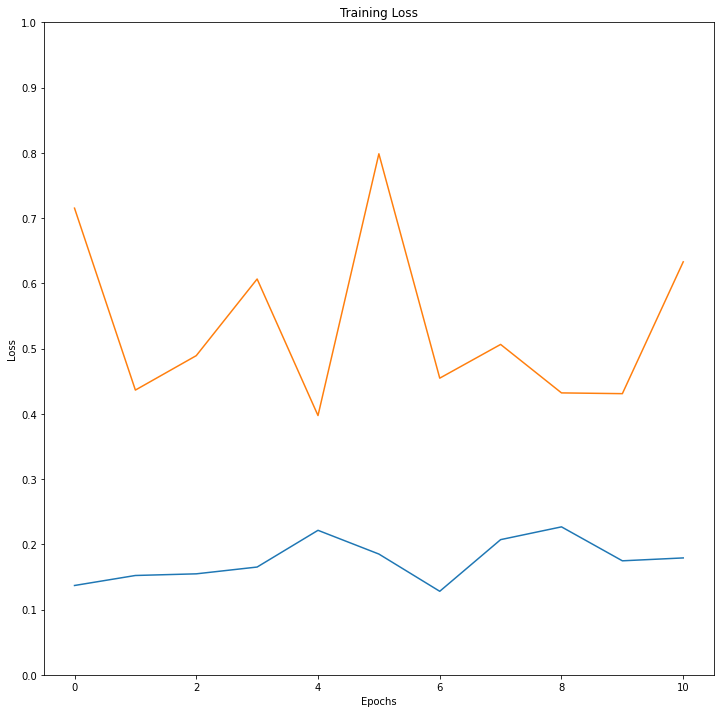

Epoch 11 		 Training Loss: 0.1791717529296875 		 Validation Loss: 0.6330847841628054


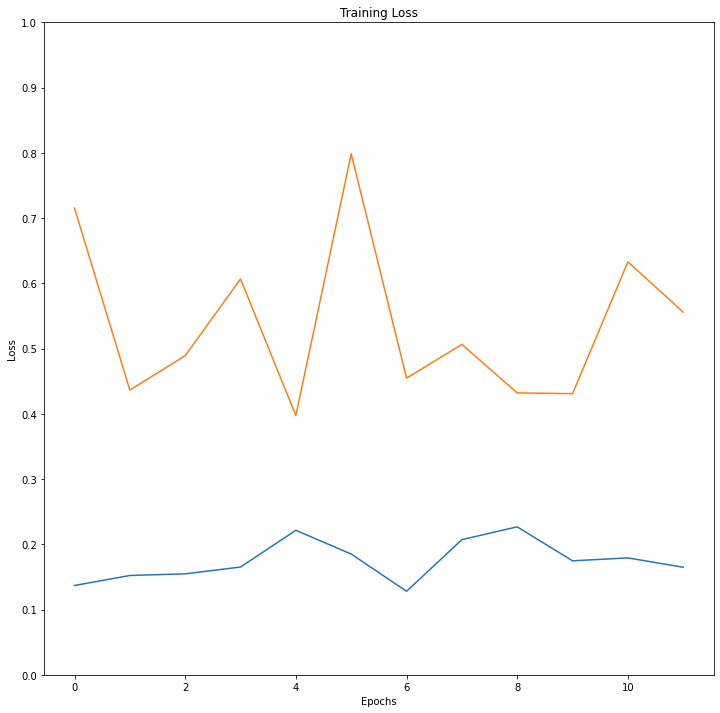

Epoch 12 		 Training Loss: 0.16488162231445314 		 Validation Loss: 0.5558938371374252


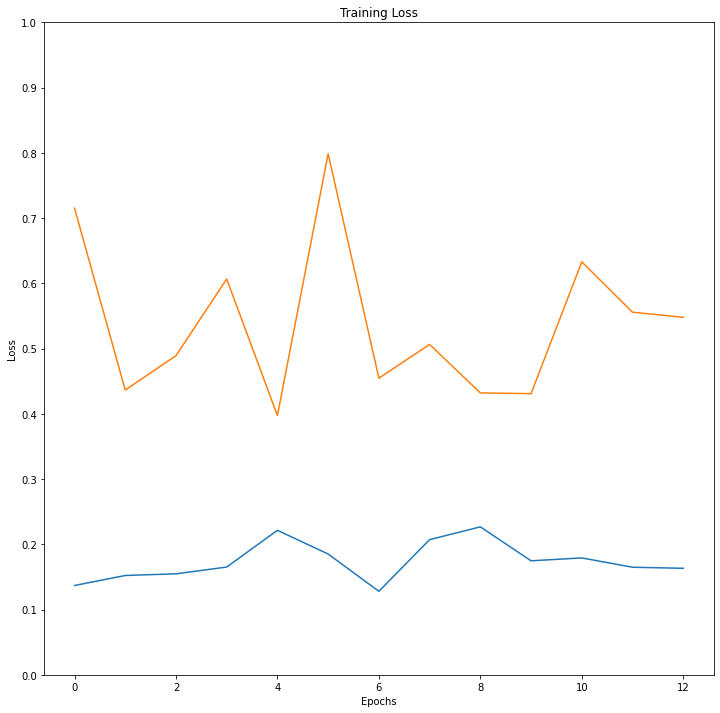

Epoch 13 		 Training Loss: 0.163267333984375 		 Validation Loss: 0.5480260240270737


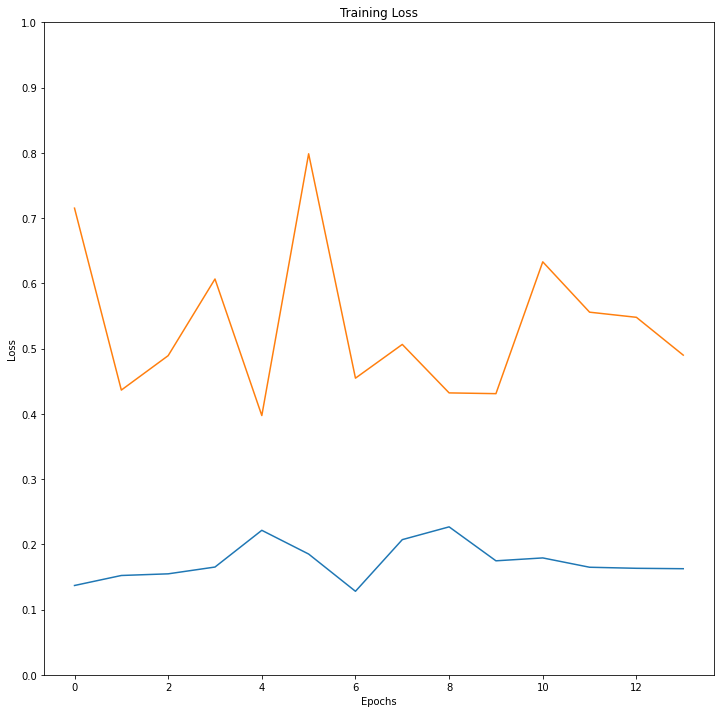

Epoch 14 		 Training Loss: 0.16263064575195313 		 Validation Loss: 0.49005603790283203


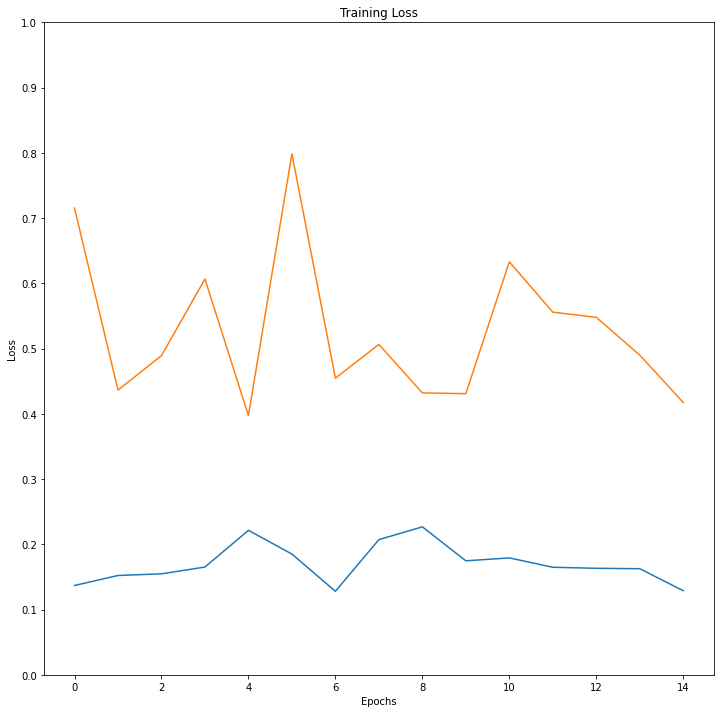

Epoch 15 		 Training Loss: 0.1288939921061198 		 Validation Loss: 0.4174889605096046


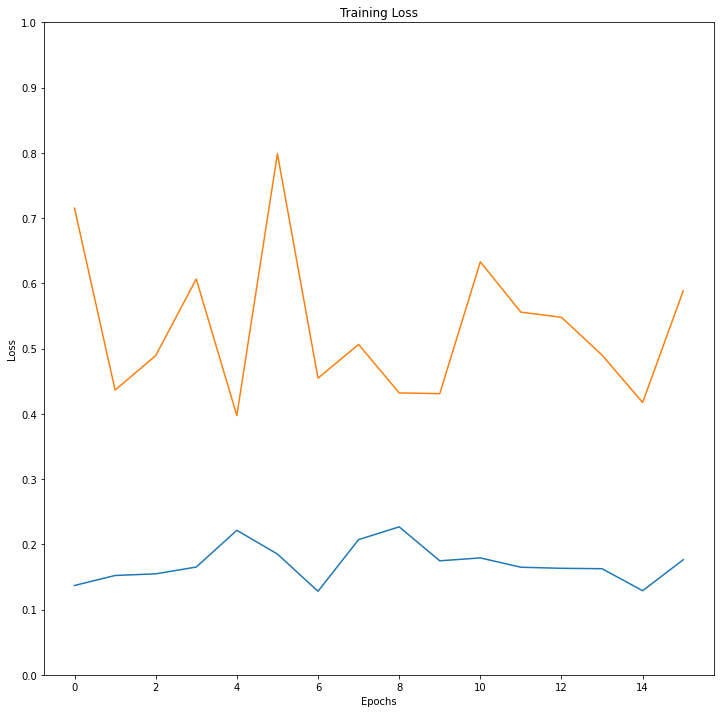

Epoch 16 		 Training Loss: 0.1764241943359375 		 Validation Loss: 0.58868408203125


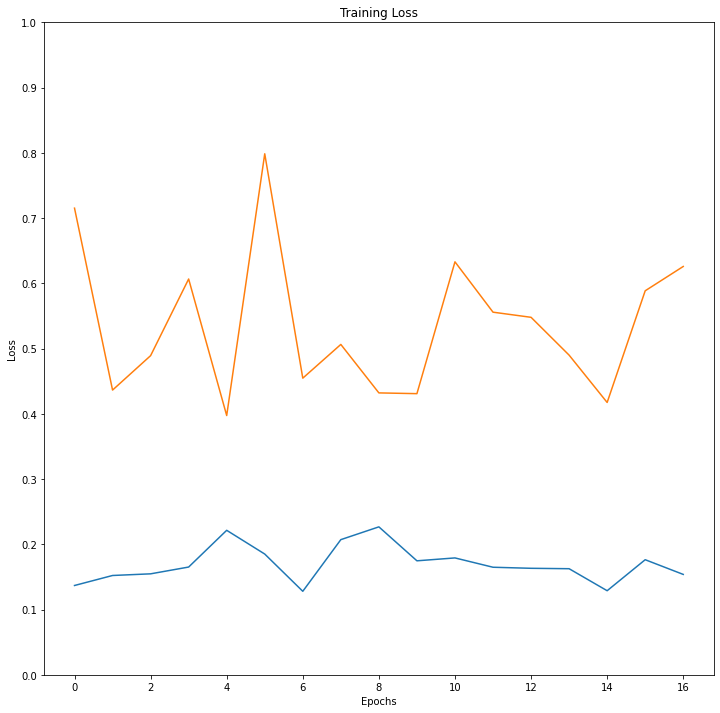

Epoch 17 		 Training Loss: 0.15389324951171876 		 Validation Loss: 0.6259694200880984


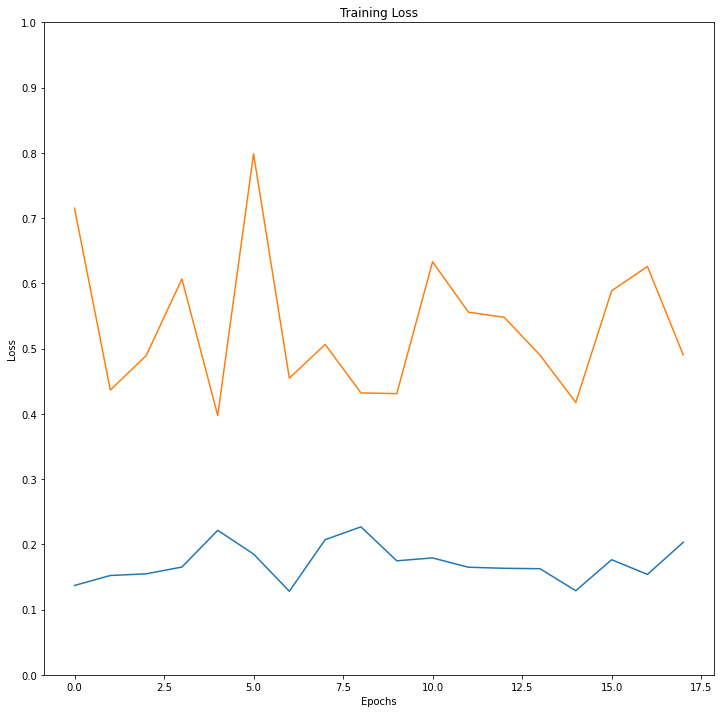

Epoch 18 		 Training Loss: 0.20308447265625 		 Validation Loss: 0.4905847488565648


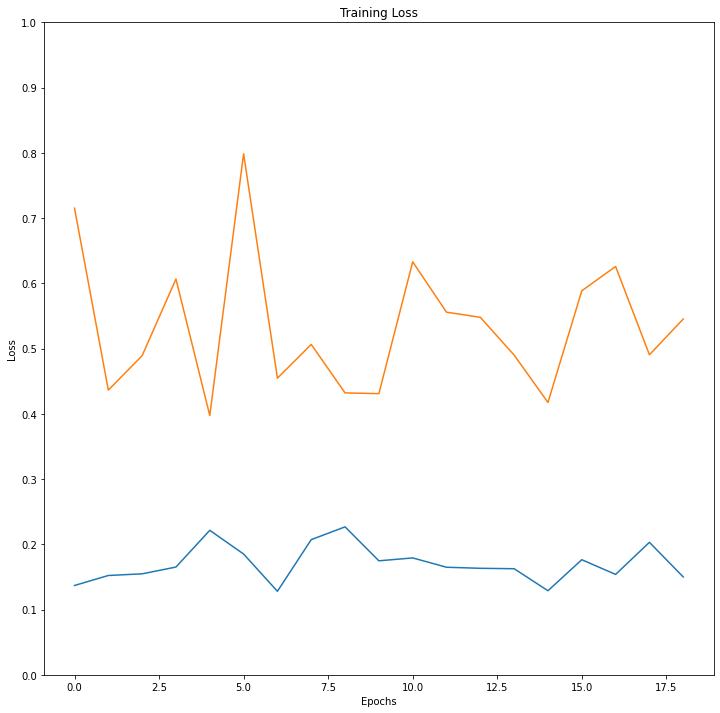

Epoch 19 		 Training Loss: 0.1499927978515625 		 Validation Loss: 0.5454498859162026


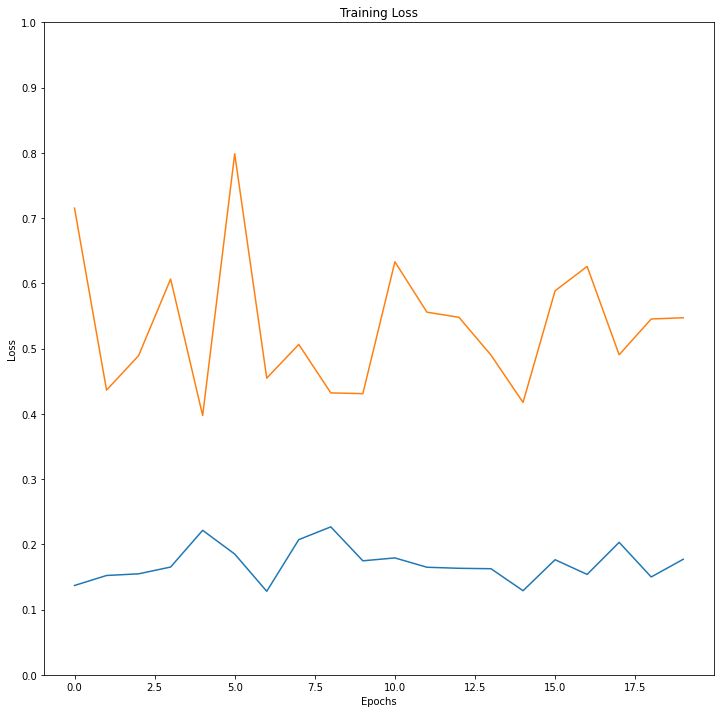

Epoch 20 		 Training Loss: 0.1771066691080729 		 Validation Loss: 0.5473438222357567


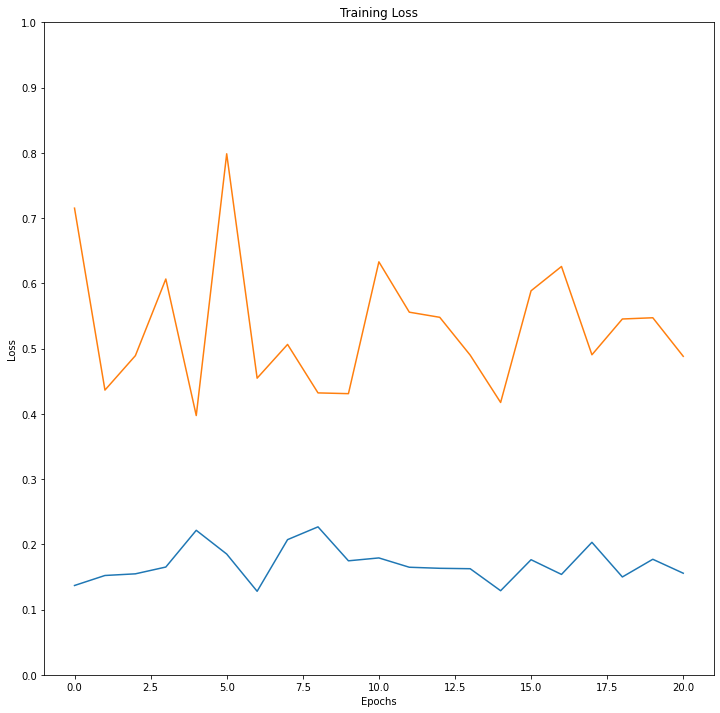

Epoch 21 		 Training Loss: 0.1557119649251302 		 Validation Loss: 0.4882199916433781


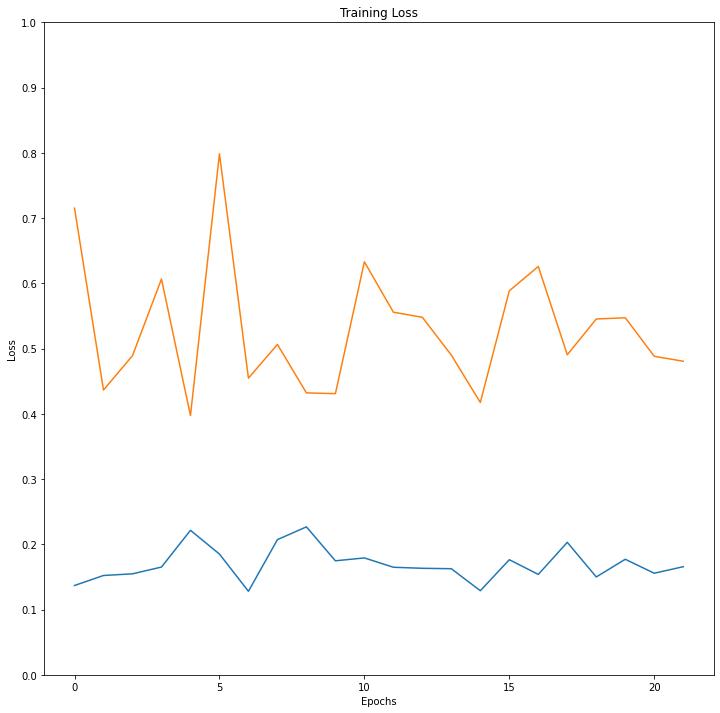

Epoch 22 		 Training Loss: 0.1657274678548177 		 Validation Loss: 0.480740394998104


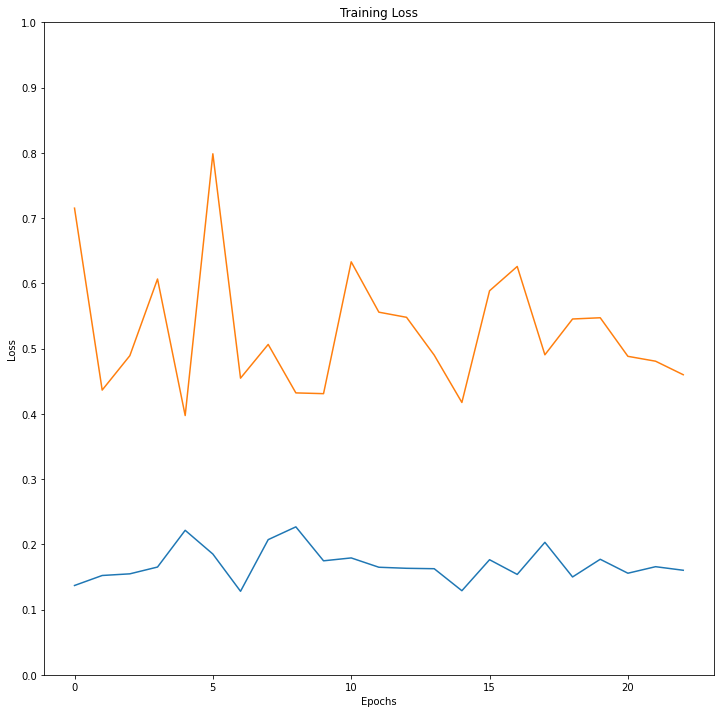

Epoch 23 		 Training Loss: 0.1602516886393229 		 Validation Loss: 0.4600047659366689


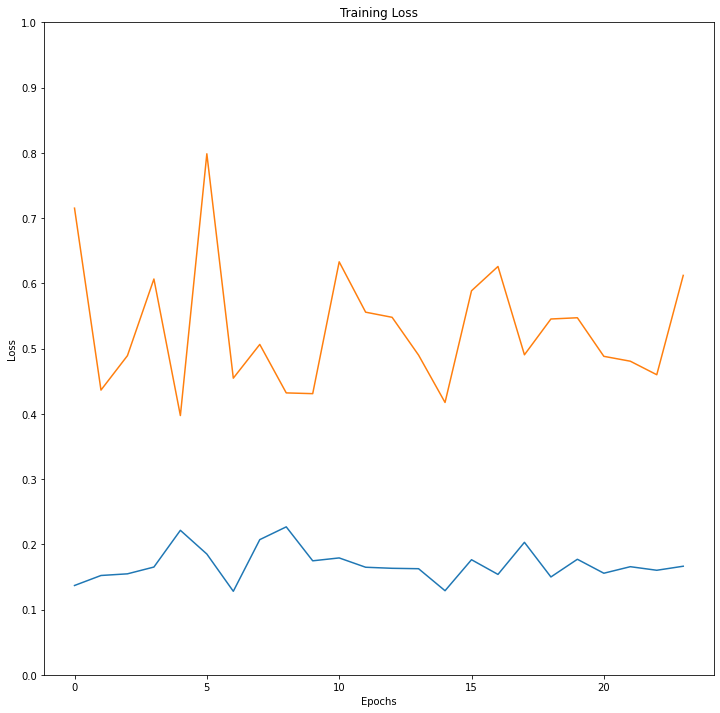

Epoch 24 		 Training Loss: 0.16644940185546875 		 Validation Loss: 0.6123035309162546


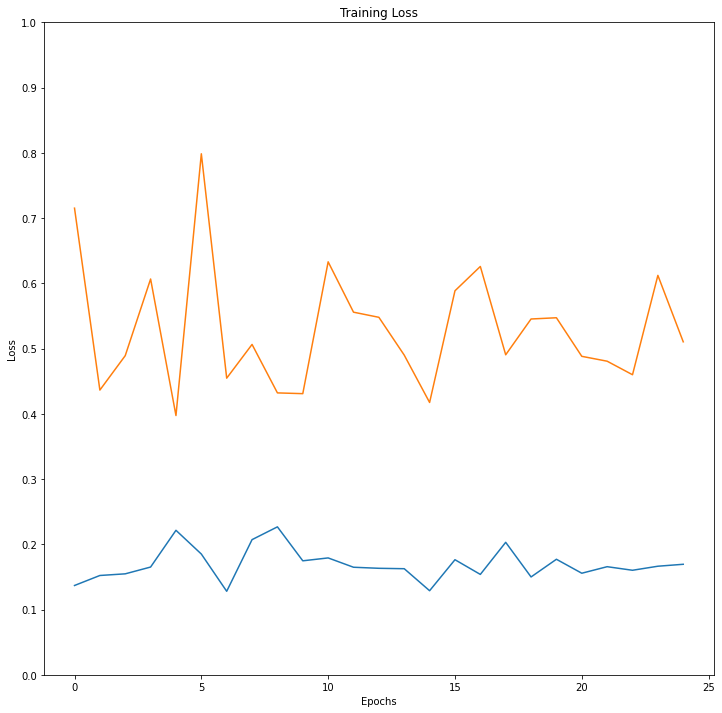

Epoch 25 		 Training Loss: 0.16942787679036458 		 Validation Loss: 0.5104680670068619


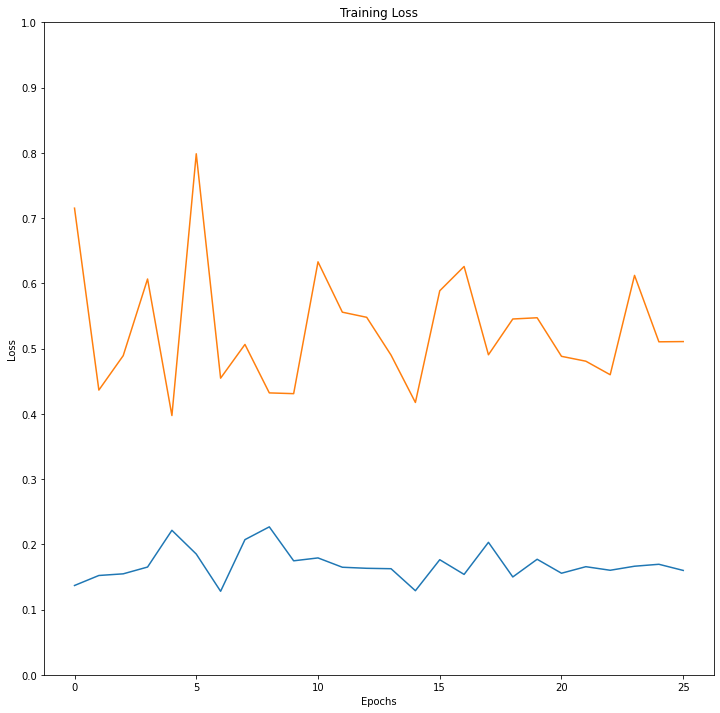

Epoch 26 		 Training Loss: 0.15998527018229167 		 Validation Loss: 0.5108293168088223


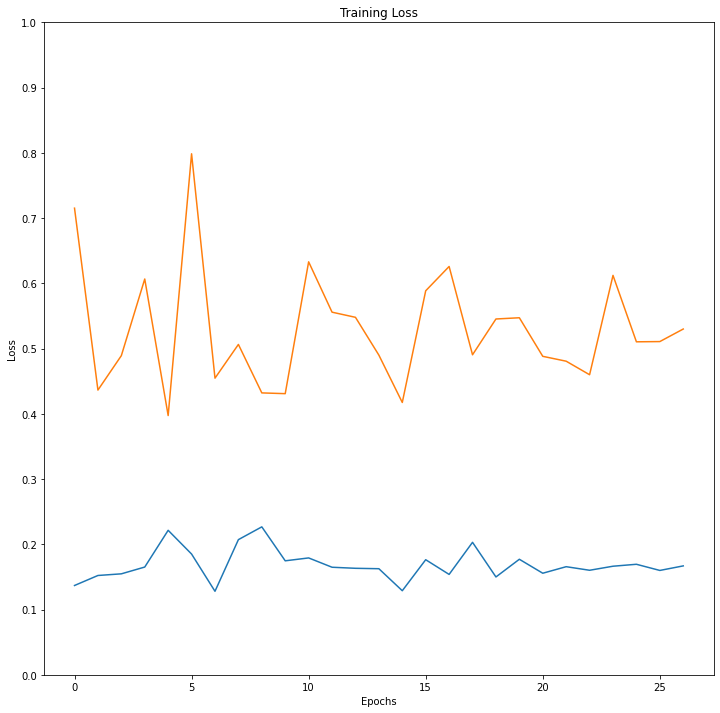

Epoch 27 		 Training Loss: 0.1669513956705729 		 Validation Loss: 0.5300700005064619


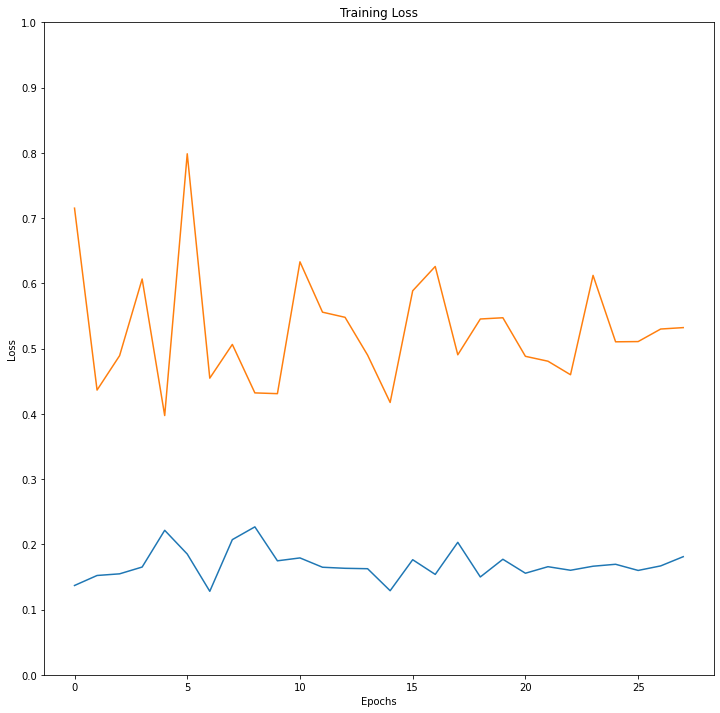

Epoch 28 		 Training Loss: 0.18107830810546874 		 Validation Loss: 0.53223488178659


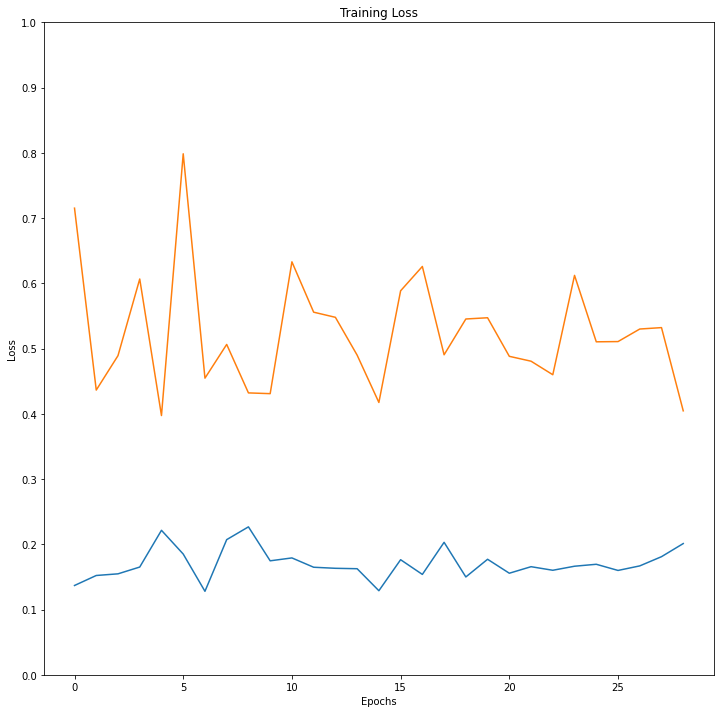

Epoch 29 		 Training Loss: 0.20118988037109375 		 Validation Loss: 0.40465404632243707


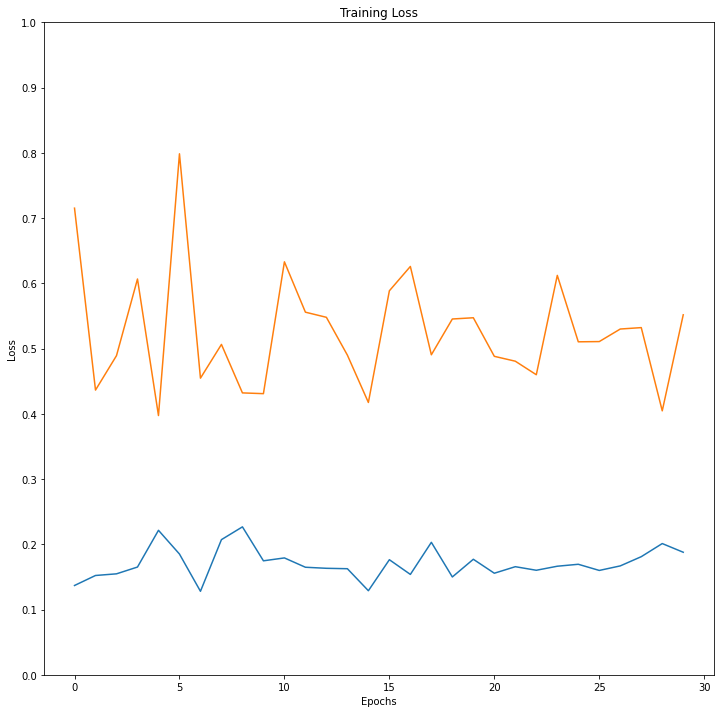

Epoch 30 		 Training Loss: 0.187863525390625 		 Validation Loss: 0.5518843265289956


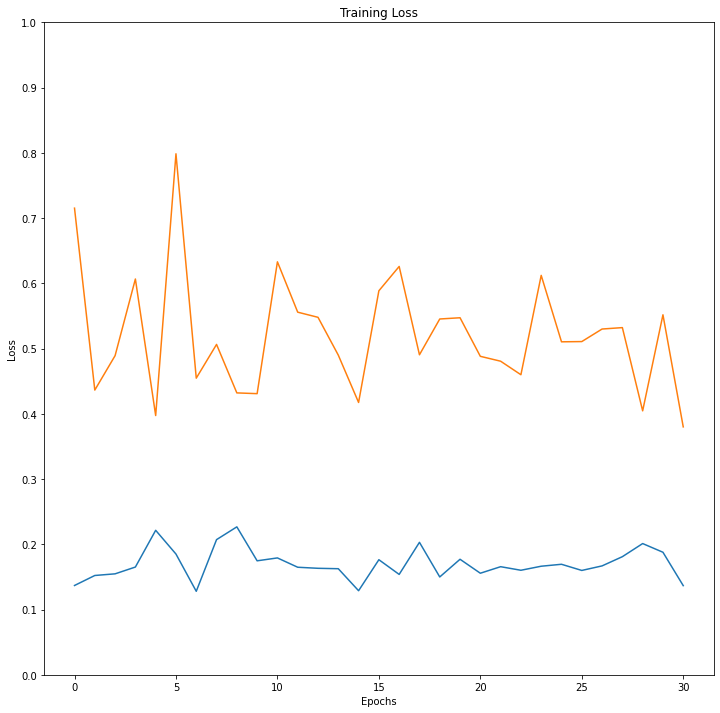

Epoch 31 		 Training Loss: 0.13667664591471354 		 Validation Loss: 0.3800701892122309
Validation Loss Decreased(37.359578--->35.726598) 	 Saving The Model


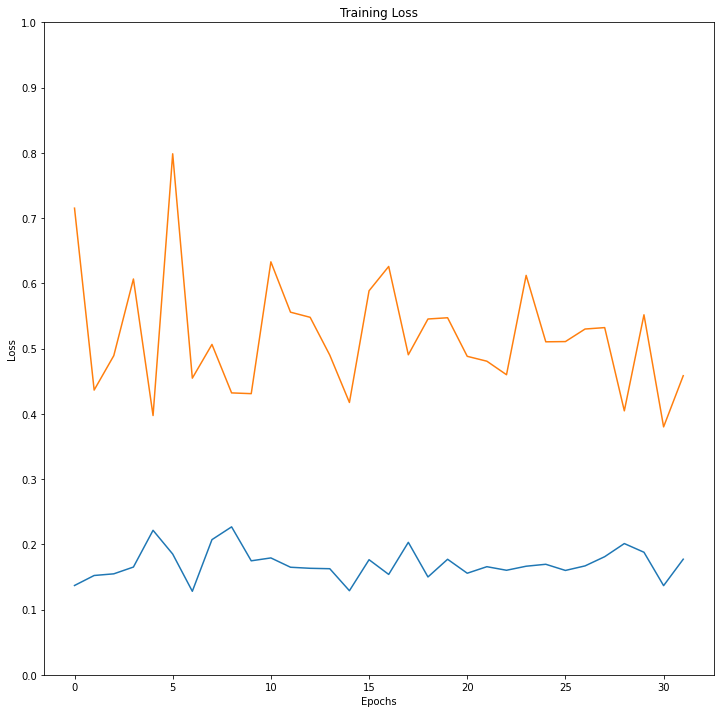

Epoch 32 		 Training Loss: 0.17721575927734376 		 Validation Loss: 0.4584992895735071


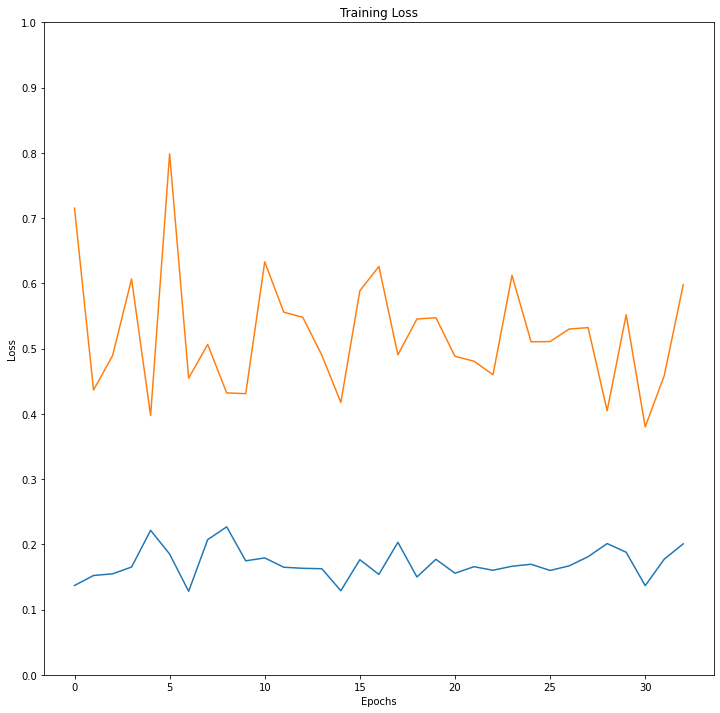

Epoch 33 		 Training Loss: 0.20075862630208333 		 Validation Loss: 0.5979381520697411


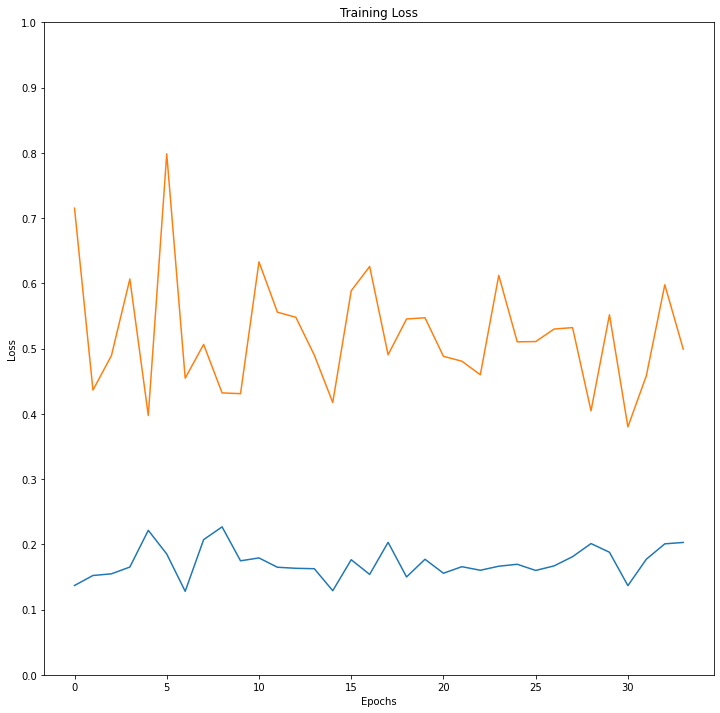

Epoch 34 		 Training Loss: 0.20289278157552082 		 Validation Loss: 0.4992797019633841


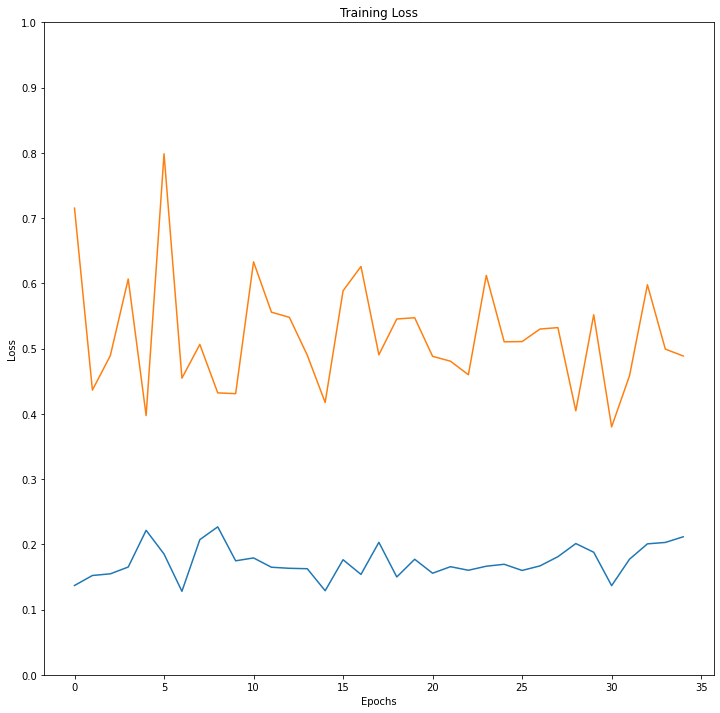

Epoch 35 		 Training Loss: 0.21158268229166666 		 Validation Loss: 0.48871747483598427


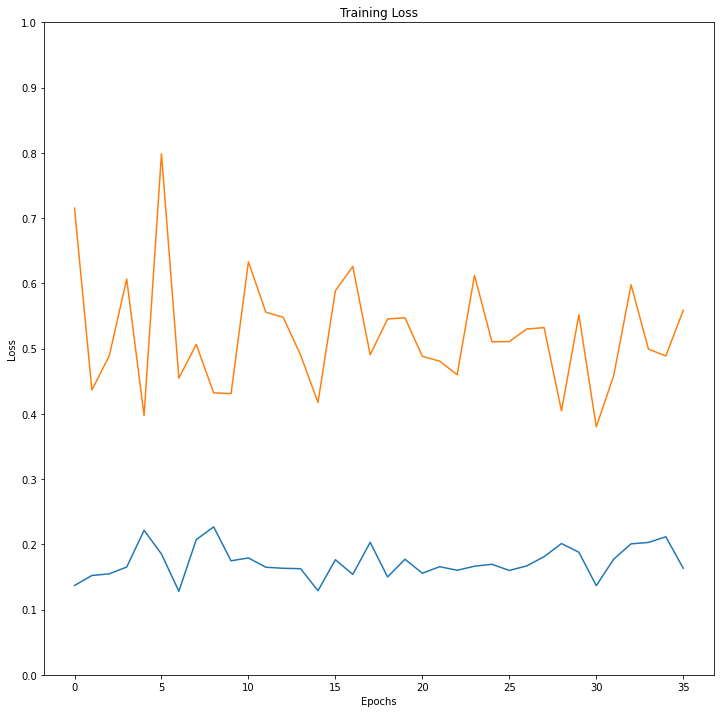

Epoch 36 		 Training Loss: 0.16329723103841146 		 Validation Loss: 0.5587852356281686


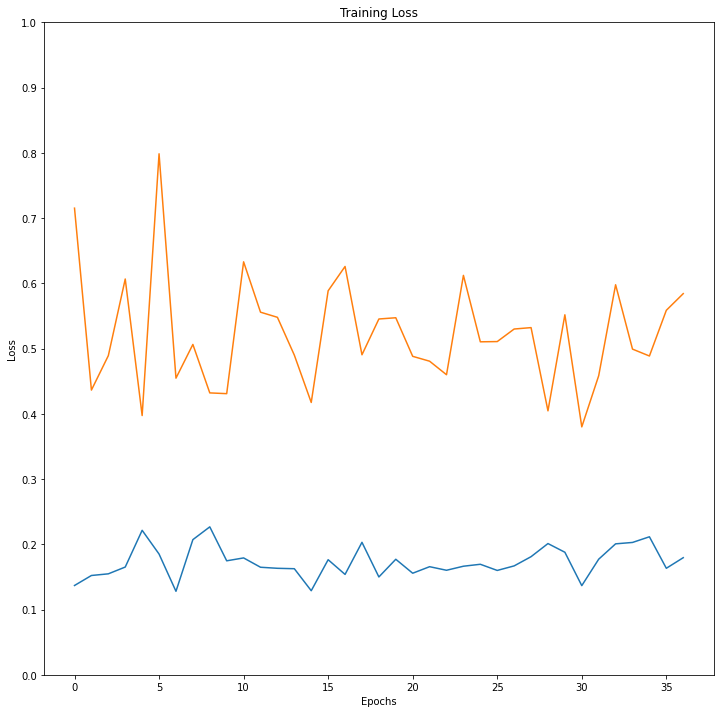

Epoch 37 		 Training Loss: 0.1795350341796875 		 Validation Loss: 0.5843267440795898


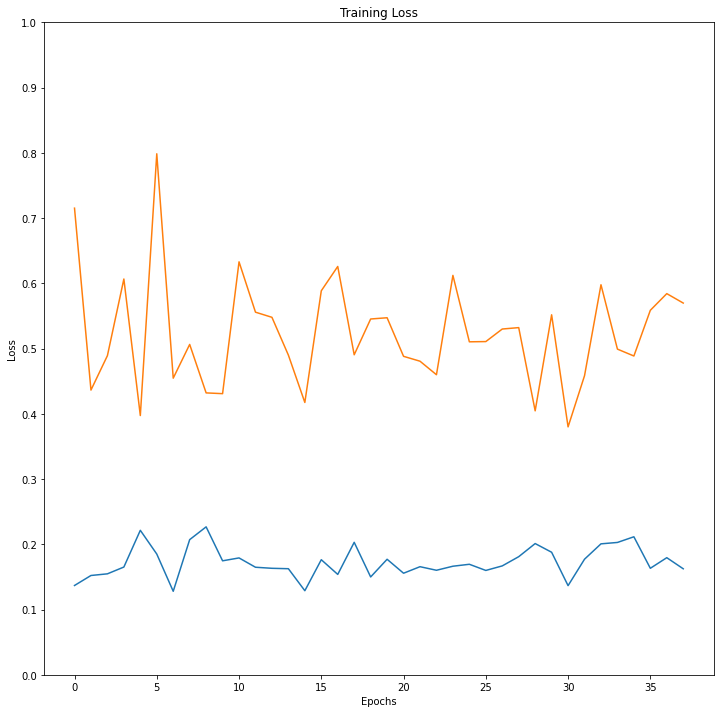

Epoch 38 		 Training Loss: 0.16252029418945313 		 Validation Loss: 0.5698737083597386


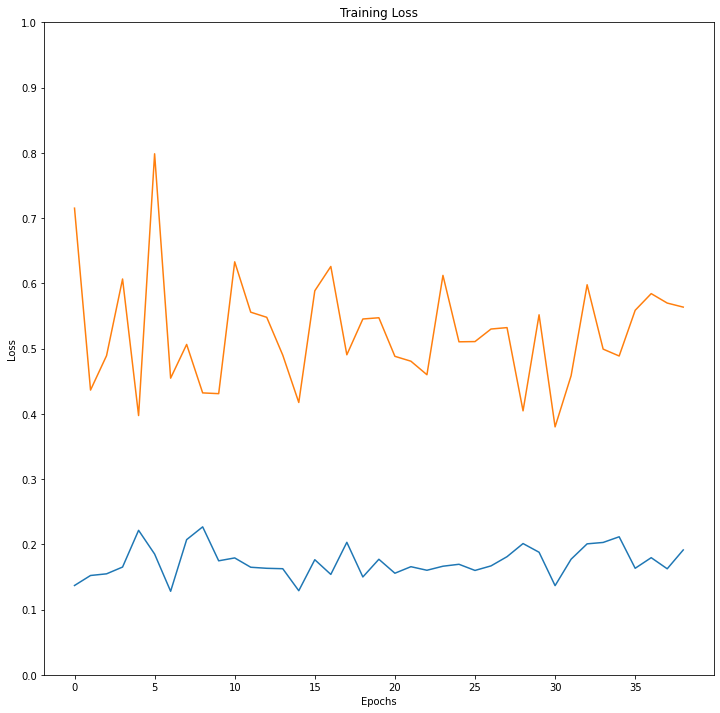

Epoch 39 		 Training Loss: 0.19141050211588542 		 Validation Loss: 0.5636637058663876


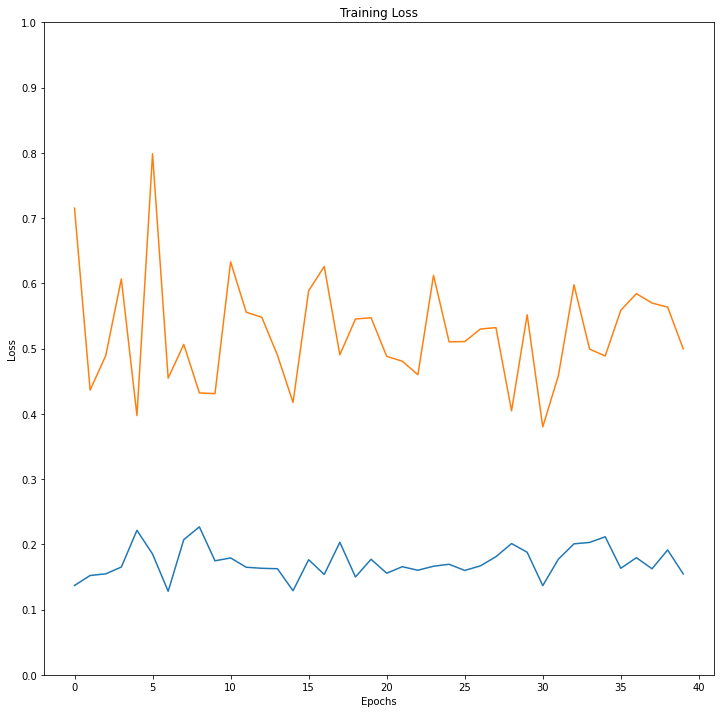

Epoch 40 		 Training Loss: 0.15463230387369792 		 Validation Loss: 0.49955067736037234


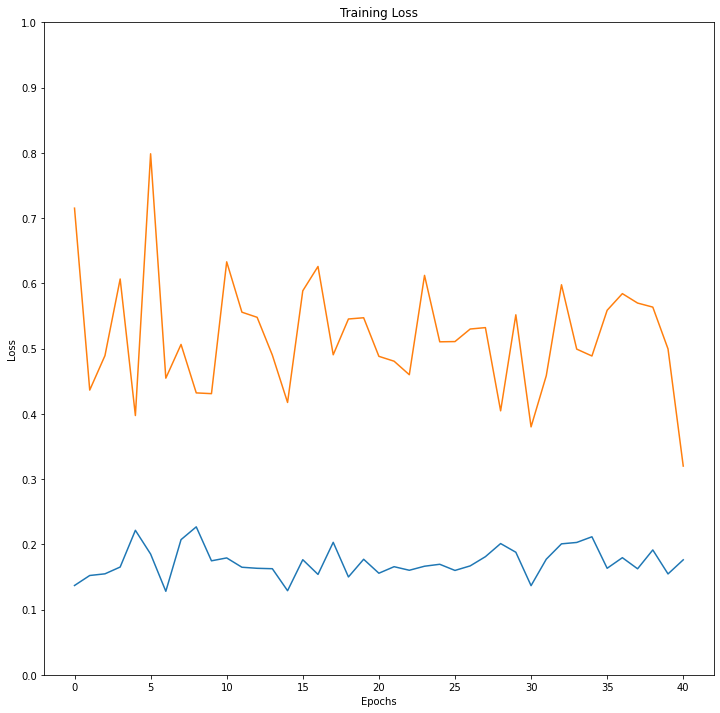

Epoch 41 		 Training Loss: 0.17625333658854167 		 Validation Loss: 0.31998055031959044
Validation Loss Decreased(35.726598--->30.078172) 	 Saving The Model


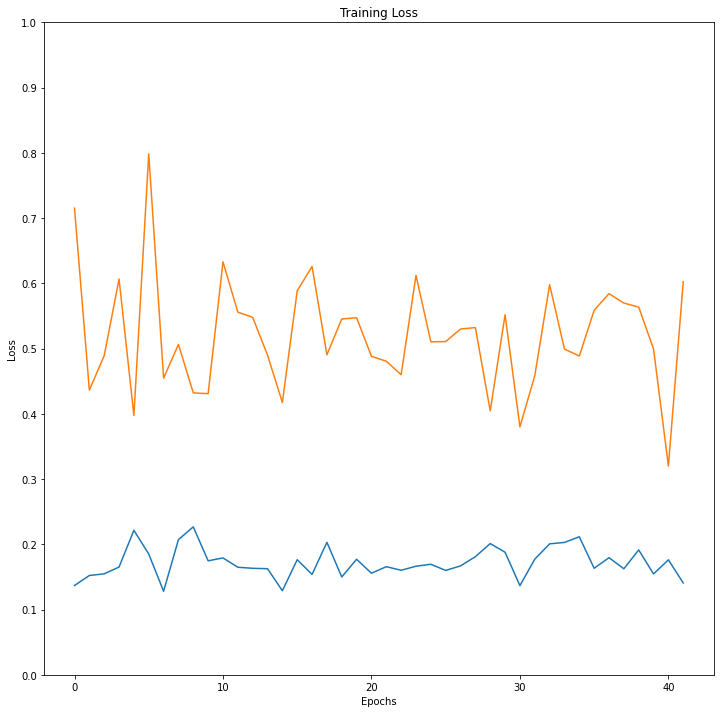

Epoch 42 		 Training Loss: 0.14081247965494792 		 Validation Loss: 0.6026084372337829


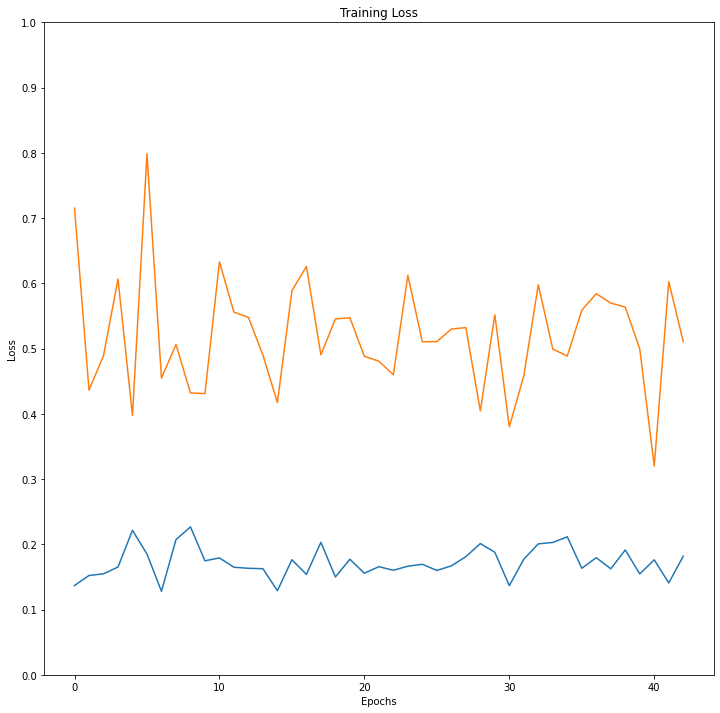

Epoch 43 		 Training Loss: 0.18177838134765625 		 Validation Loss: 0.510803019746821


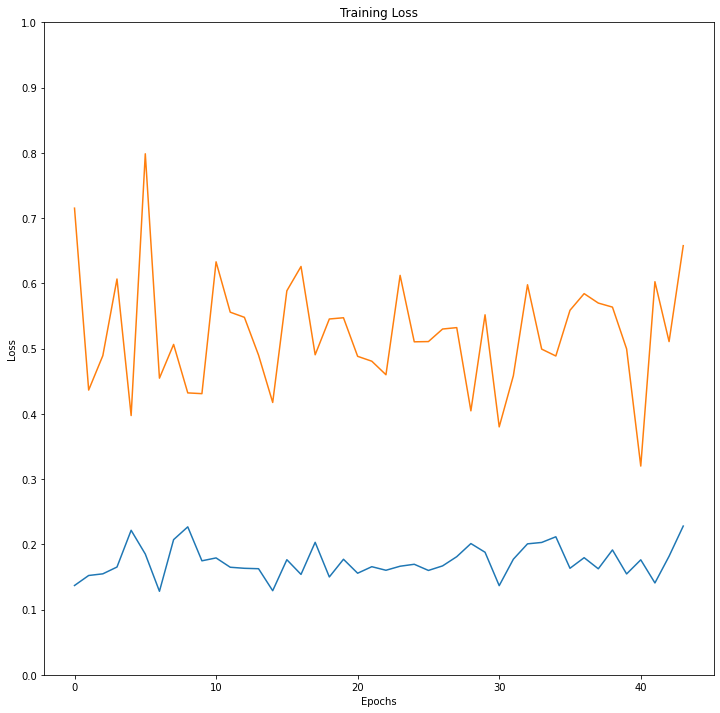

Epoch 44 		 Training Loss: 0.22801422119140624 		 Validation Loss: 0.6578563730767433


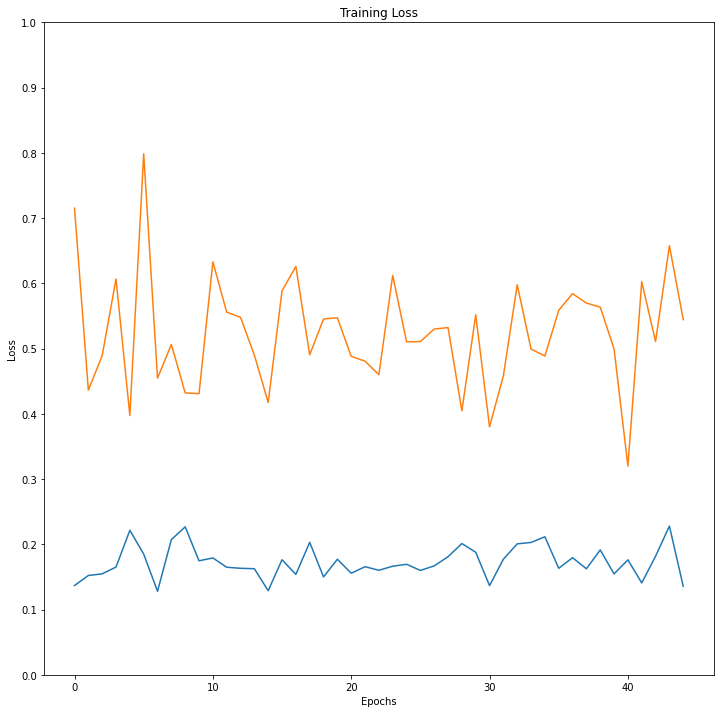

Epoch 45 		 Training Loss: 0.1356861572265625 		 Validation Loss: 0.5445079397647938


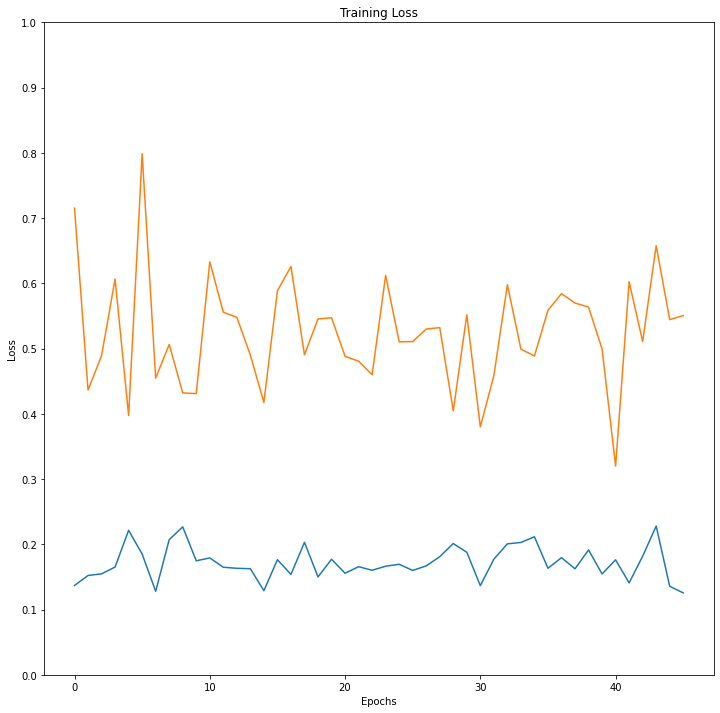

Epoch 46 		 Training Loss: 0.1255655721028646 		 Validation Loss: 0.5506962106582967


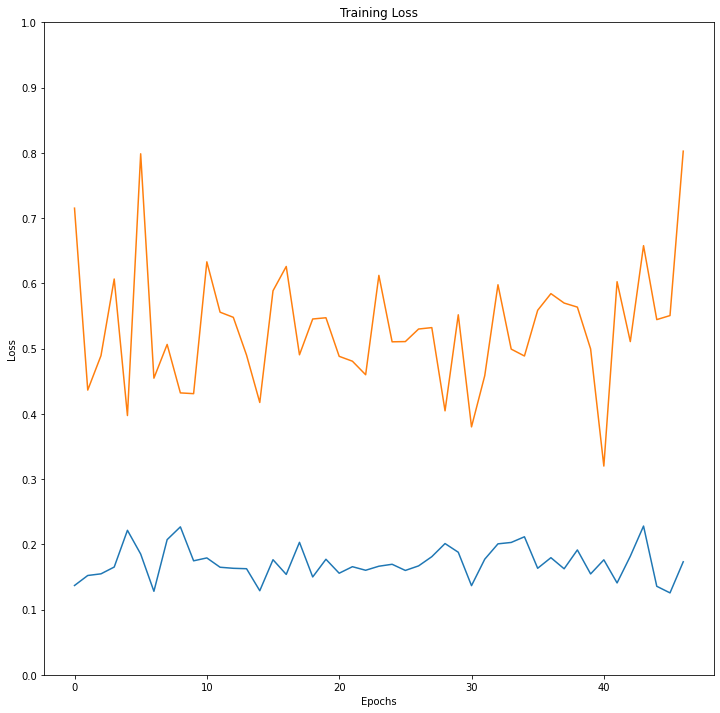

Epoch 47 		 Training Loss: 0.17326595052083332 		 Validation Loss: 0.8027435667971348


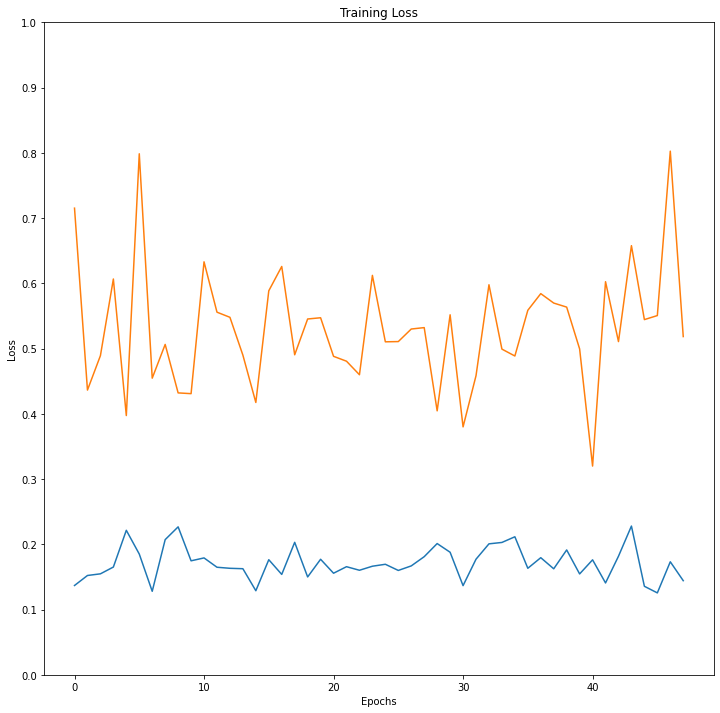

Epoch 48 		 Training Loss: 0.14429790242513021 		 Validation Loss: 0.5185106764448449


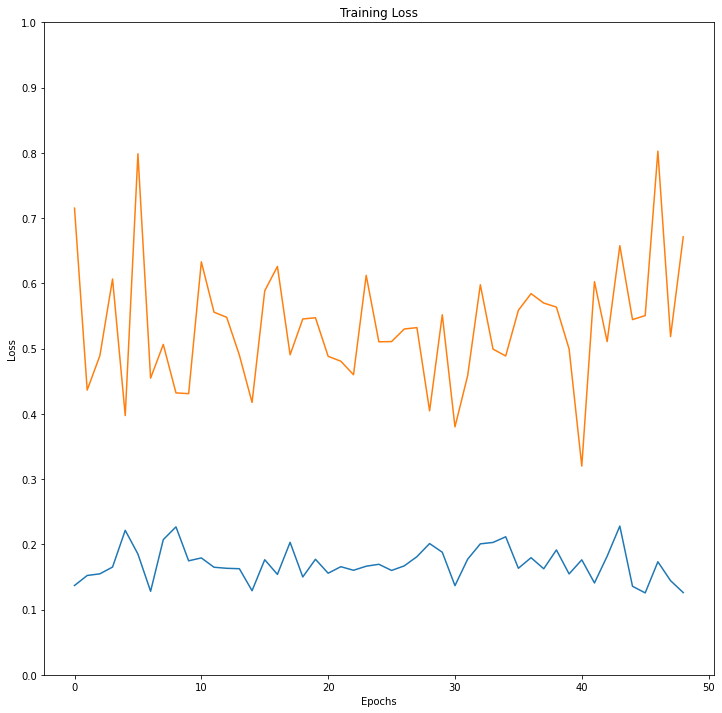

Epoch 49 		 Training Loss: 0.12601924641927084 		 Validation Loss: 0.6713793937196123


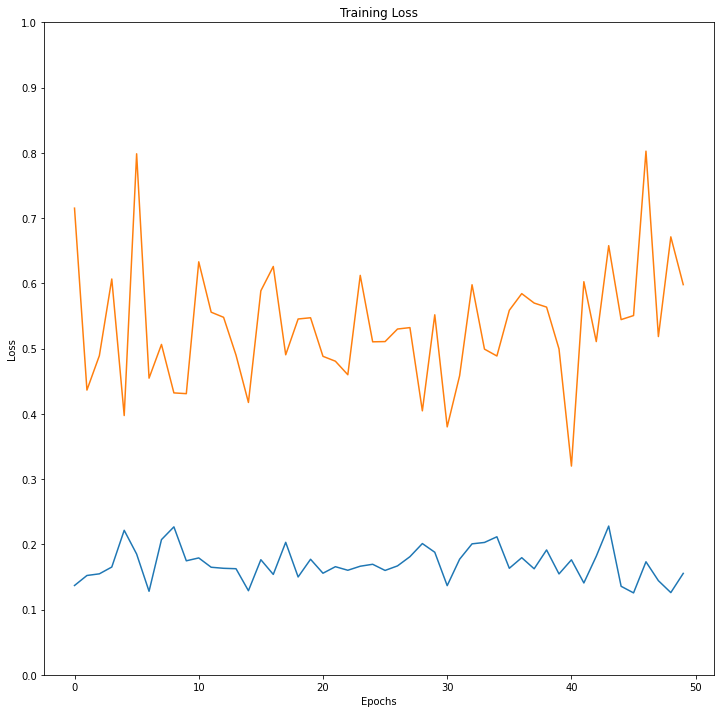

Epoch 50 		 Training Loss: 0.15544734700520832 		 Validation Loss: 0.5981321537748296


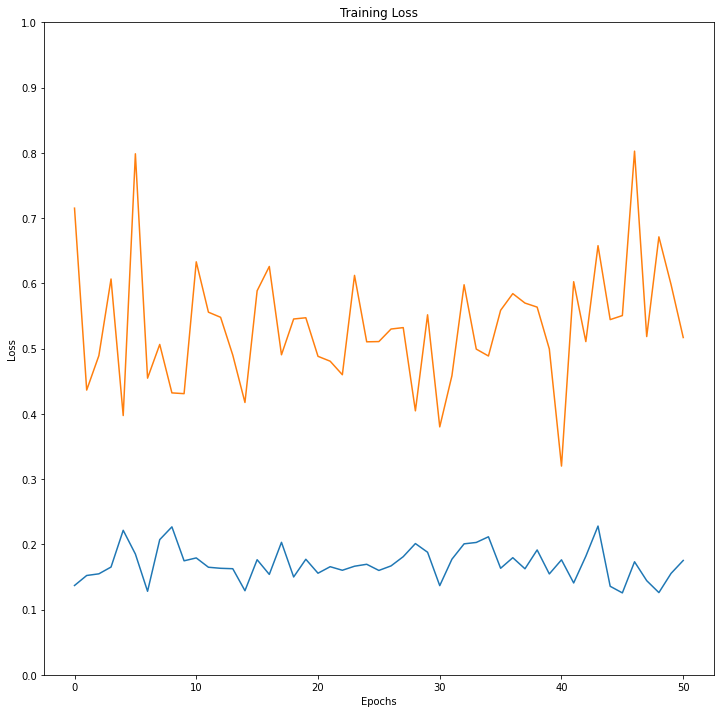

Epoch 51 		 Training Loss: 0.1753014933268229 		 Validation Loss: 0.5170481458623358


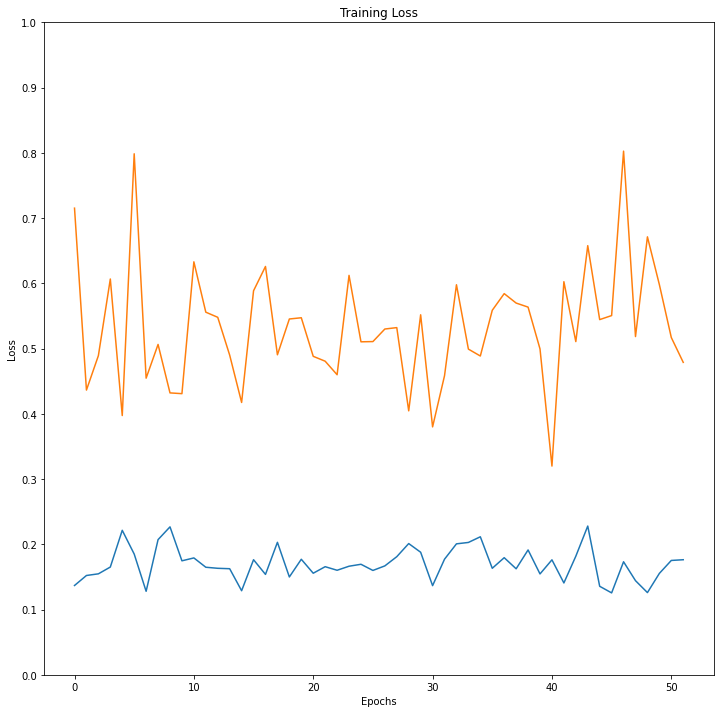

Epoch 52 		 Training Loss: 0.17639945475260416 		 Validation Loss: 0.4789612648334909


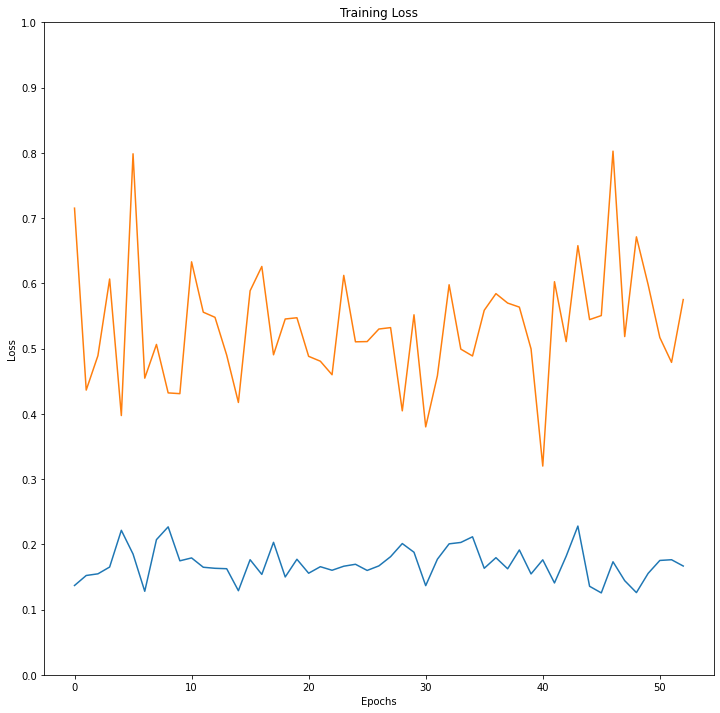

Epoch 53 		 Training Loss: 0.16675191243489584 		 Validation Loss: 0.5752030027673599


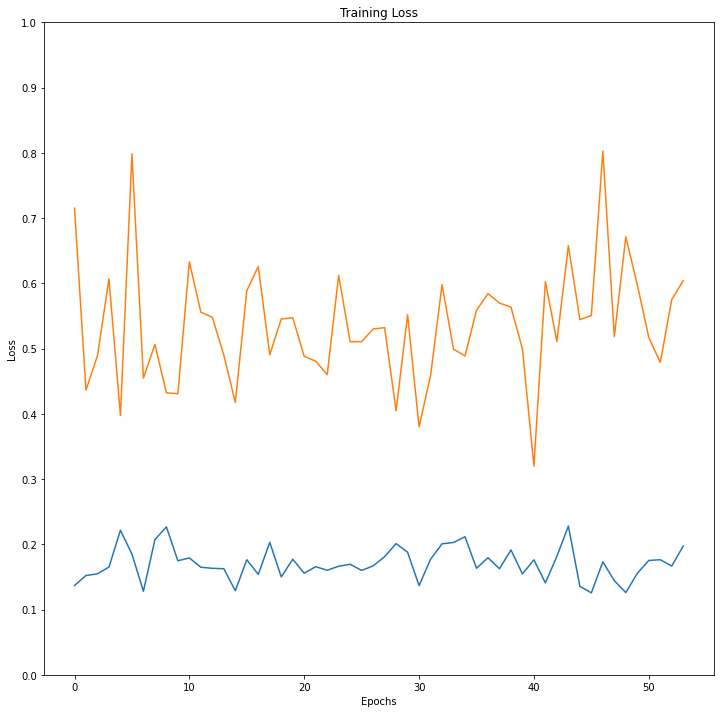

Epoch 54 		 Training Loss: 0.19745515950520834 		 Validation Loss: 0.6042913274562105


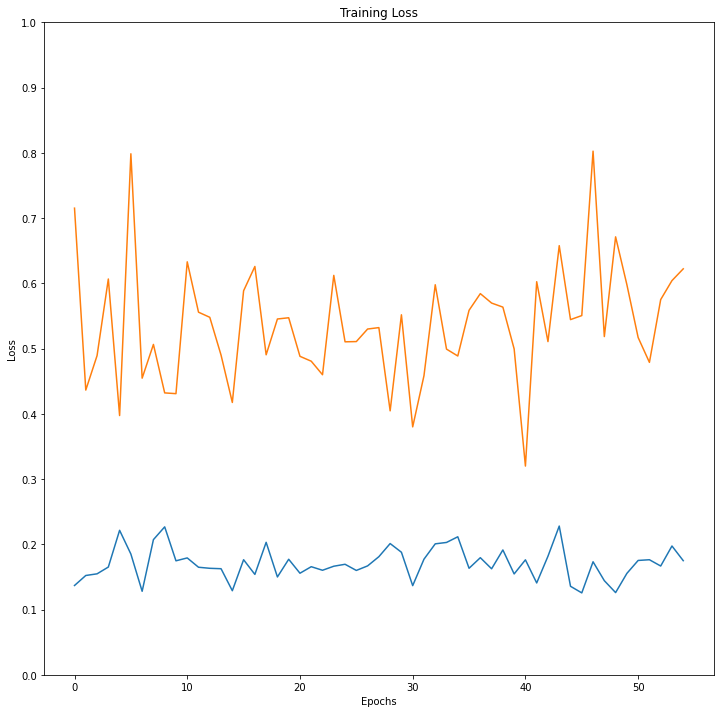

Epoch 55 		 Training Loss: 0.17496175130208333 		 Validation Loss: 0.6223440170288086


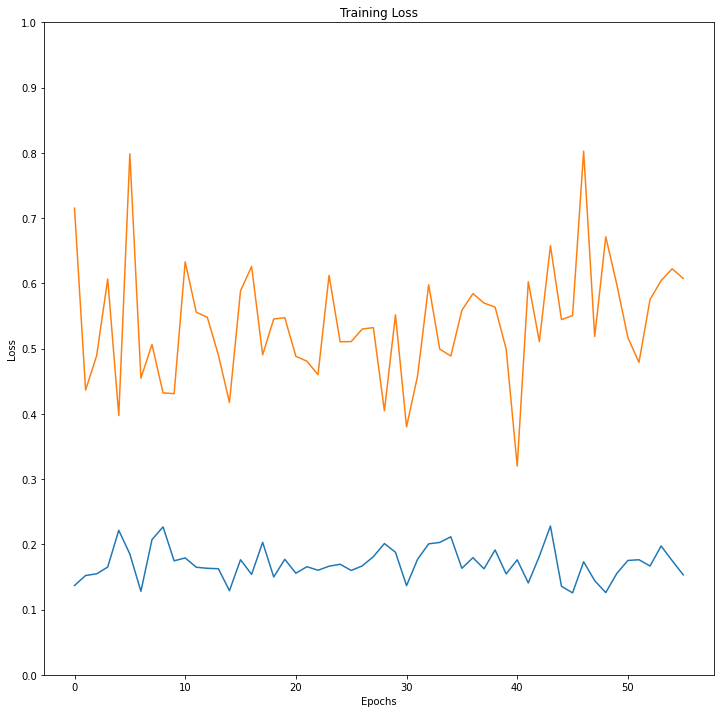

Epoch 56 		 Training Loss: 0.1532218017578125 		 Validation Loss: 0.6075637898546584


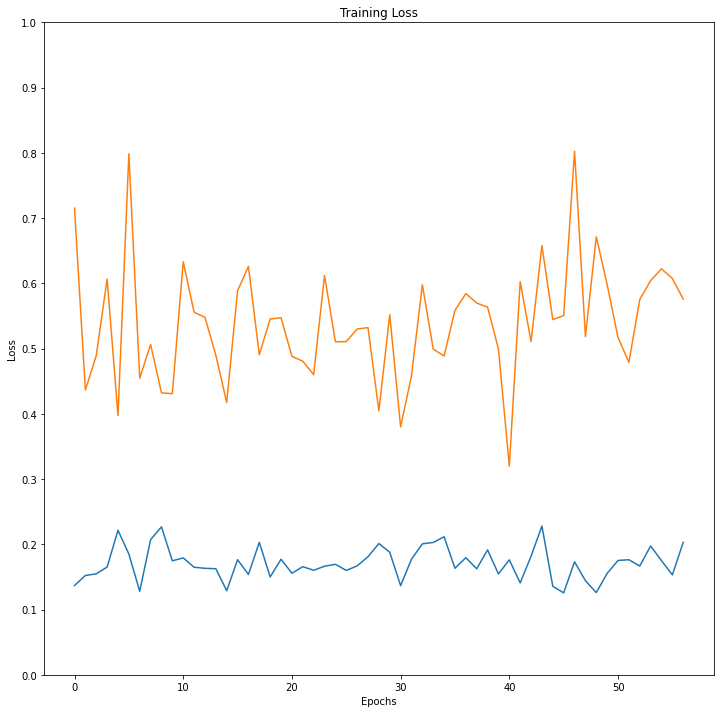

Epoch 57 		 Training Loss: 0.2031556396484375 		 Validation Loss: 0.5759847316336124


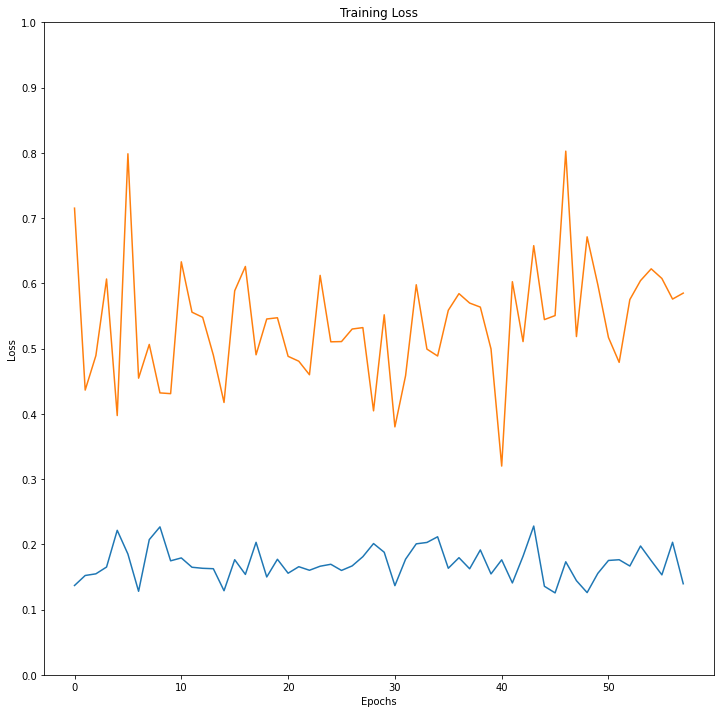

Epoch 58 		 Training Loss: 0.13957115681966145 		 Validation Loss: 0.5851126731710231


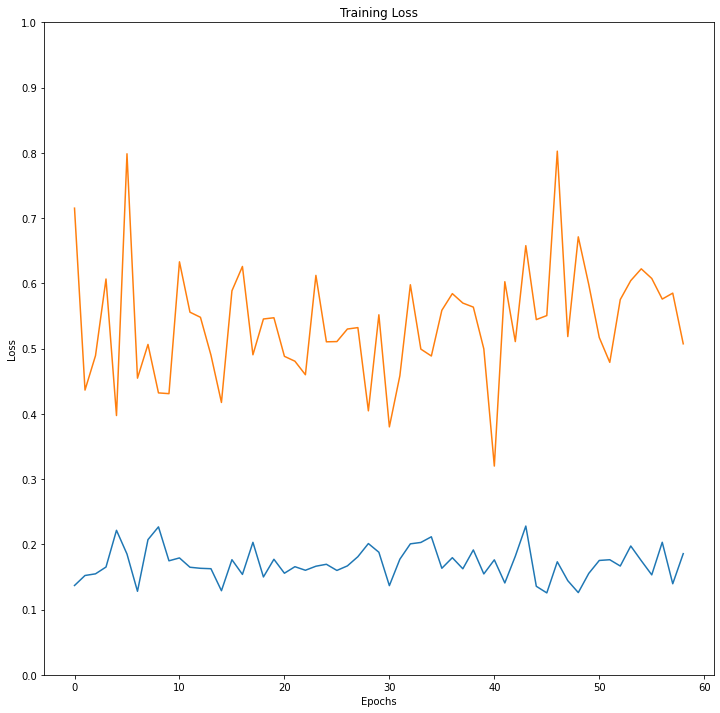

Epoch 59 		 Training Loss: 0.18571272786458334 		 Validation Loss: 0.5073984633100793


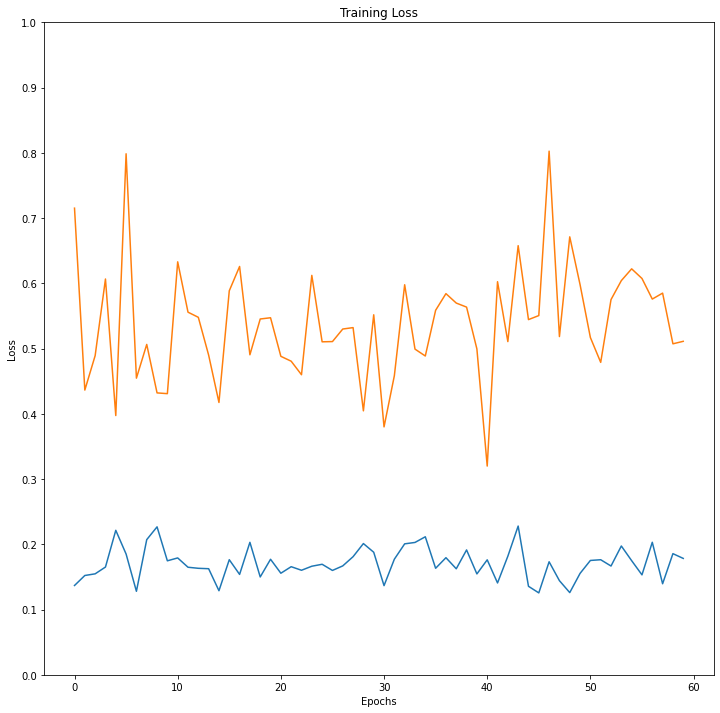

Epoch 60 		 Training Loss: 0.17842081705729165 		 Validation Loss: 0.5112227987735829


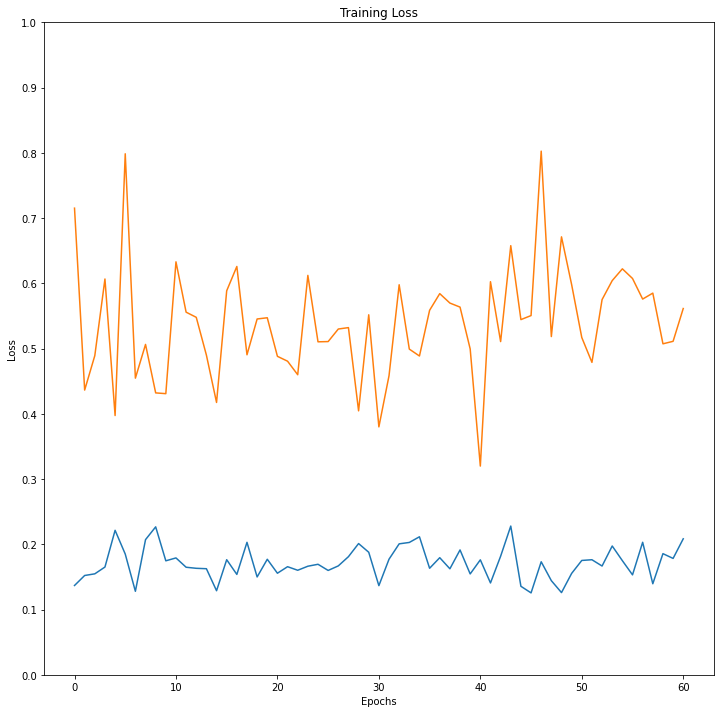

Epoch 61 		 Training Loss: 0.20847843424479168 		 Validation Loss: 0.5614996768058614


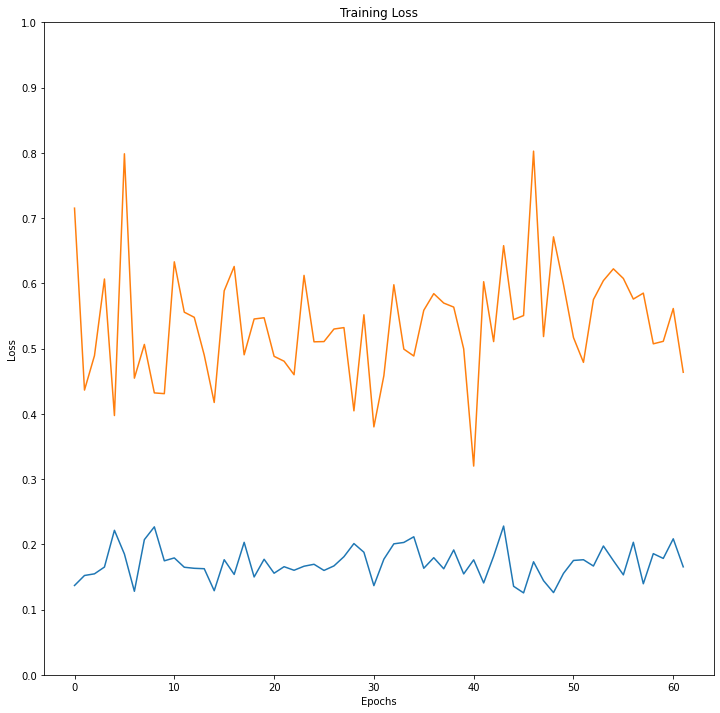

Epoch 62 		 Training Loss: 0.1654968465169271 		 Validation Loss: 0.463801069462553


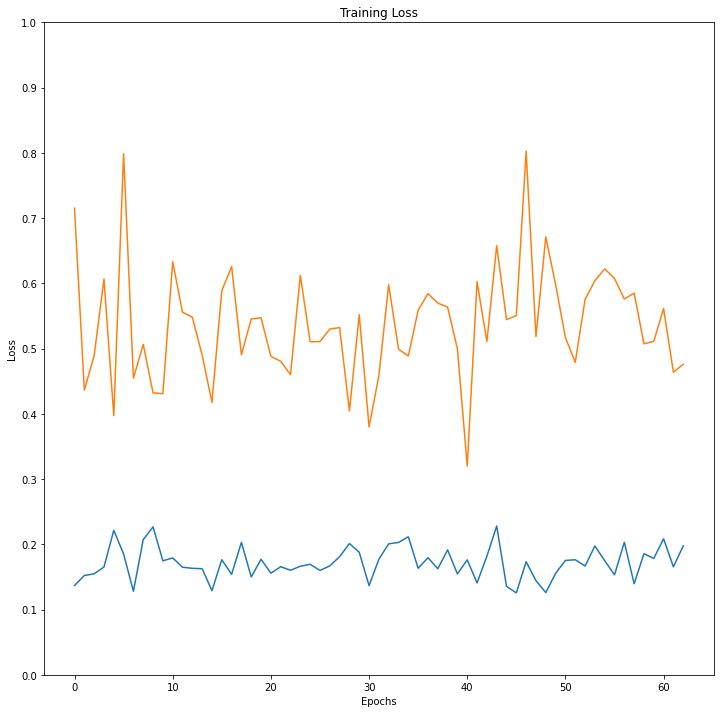

Epoch 63 		 Training Loss: 0.1976695353190104 		 Validation Loss: 0.47609521987590386


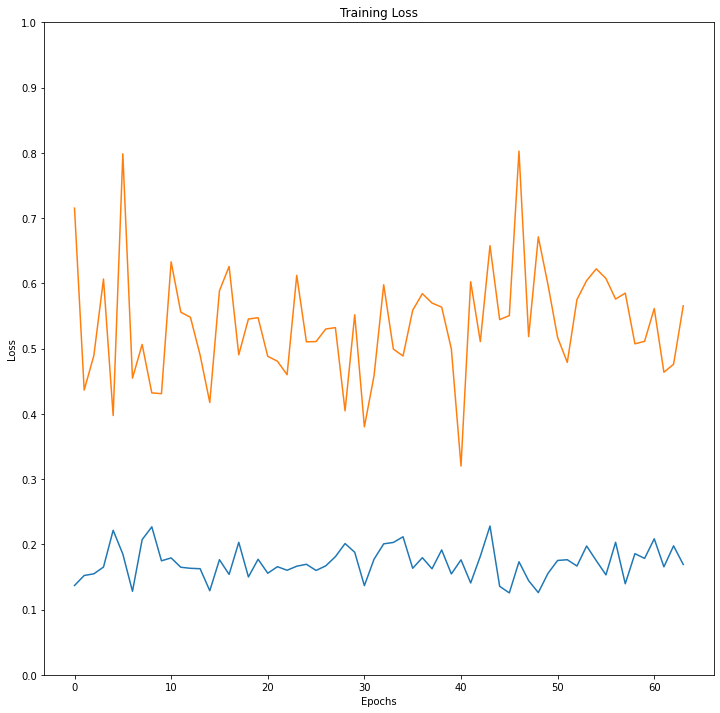

Epoch 64 		 Training Loss: 0.16912975056966145 		 Validation Loss: 0.5656171149395882


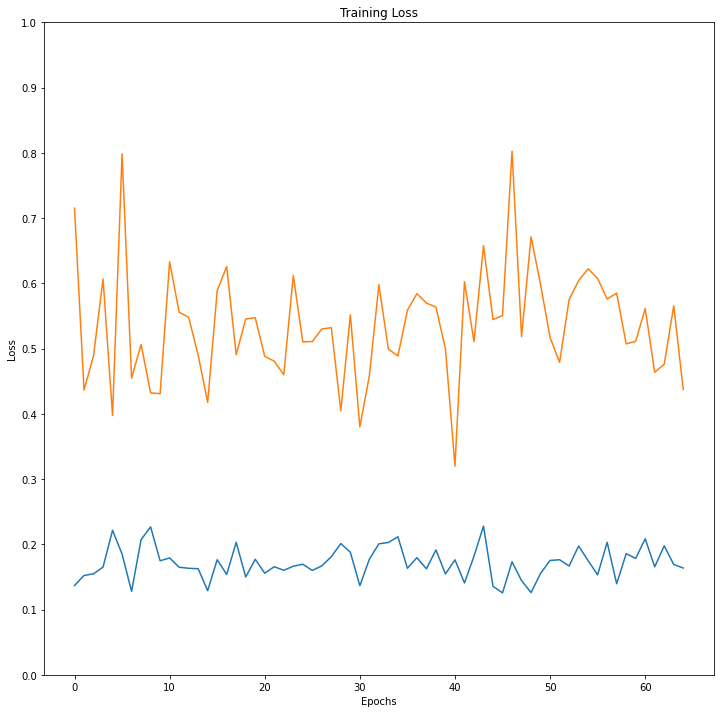

Epoch 65 		 Training Loss: 0.16367635091145832 		 Validation Loss: 0.4373678958162348


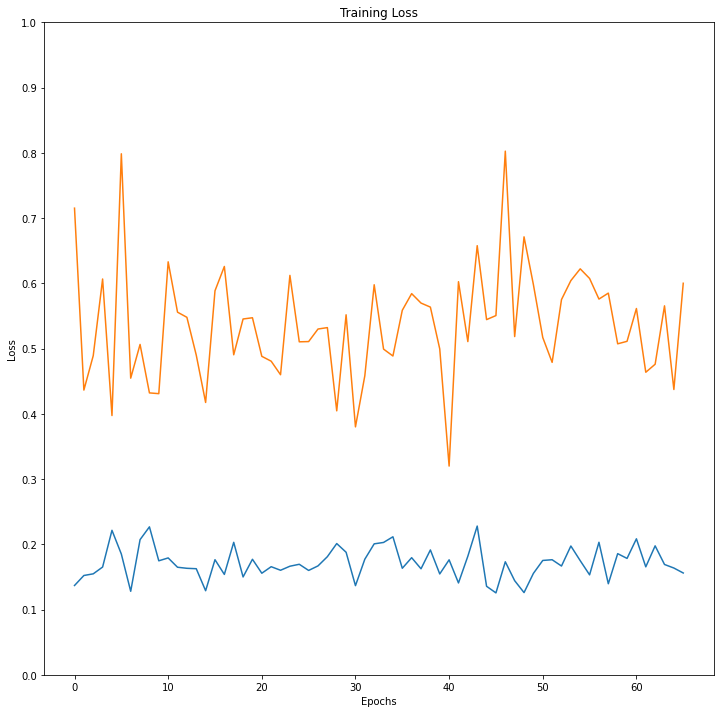

Epoch 66 		 Training Loss: 0.15607530721028645 		 Validation Loss: 0.6002189960885556


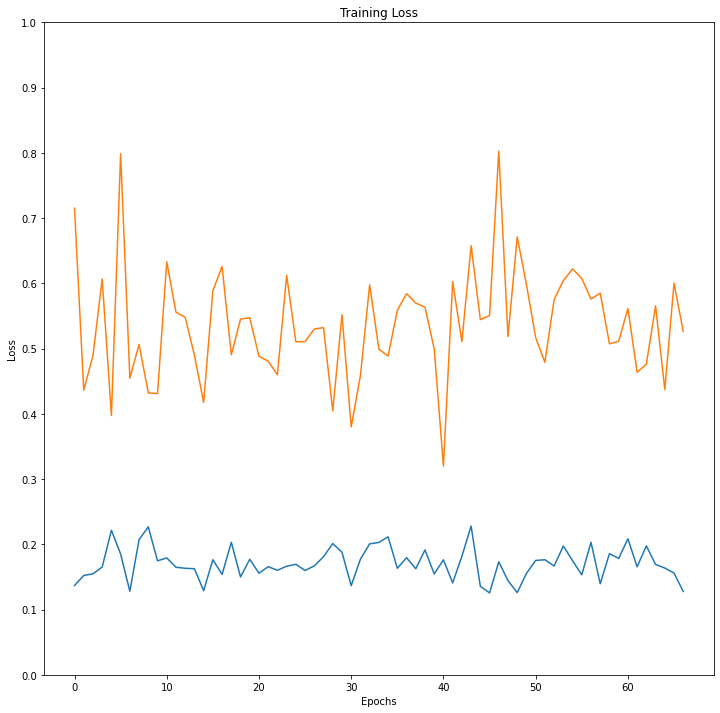

Epoch 67 		 Training Loss: 0.12768761189778646 		 Validation Loss: 0.5264260921072452


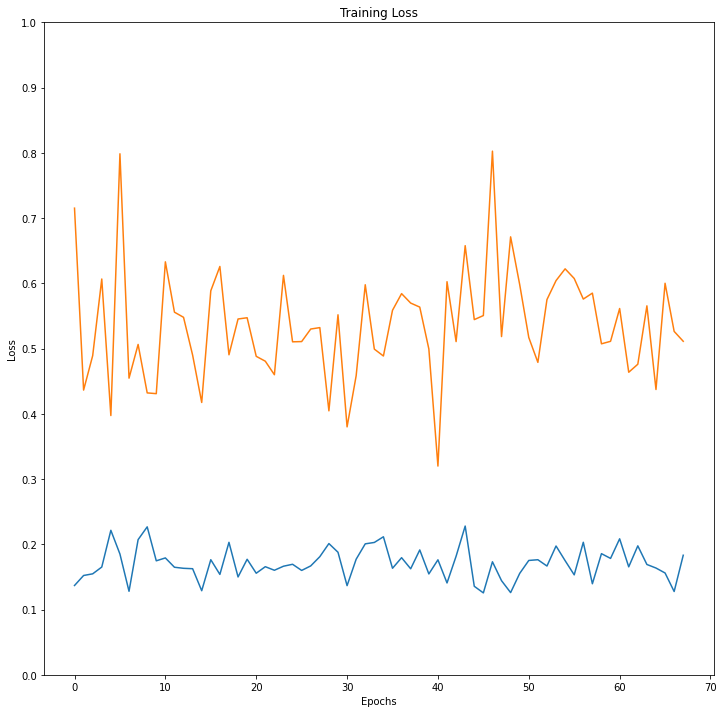

Epoch 68 		 Training Loss: 0.18328861490885417 		 Validation Loss: 0.5112615138926404


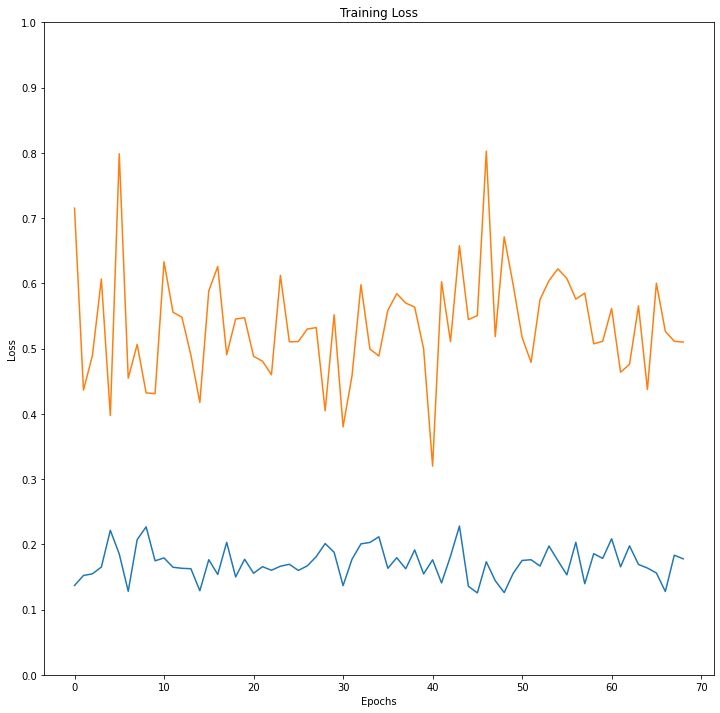

Epoch 69 		 Training Loss: 0.17777982584635416 		 Validation Loss: 0.5100612234562001


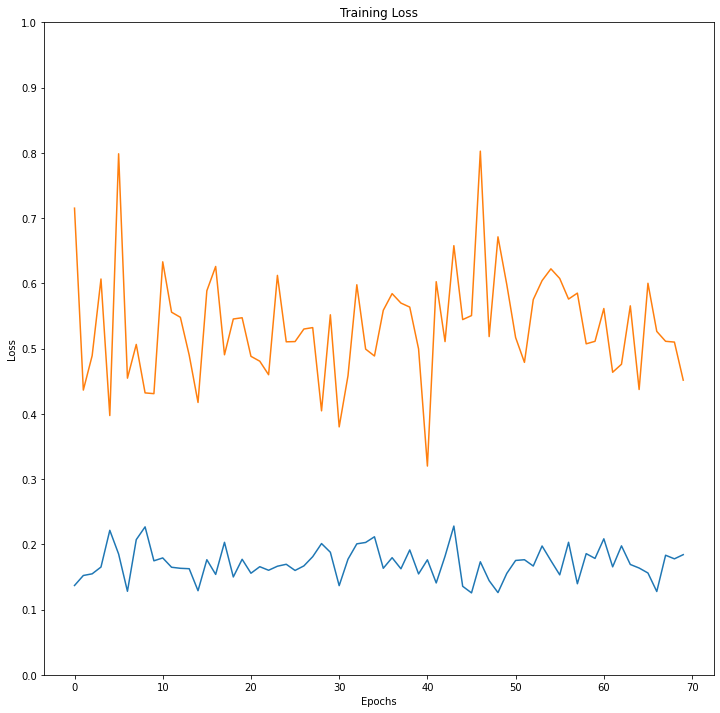

Epoch 70 		 Training Loss: 0.18418898518880208 		 Validation Loss: 0.4516843024720537


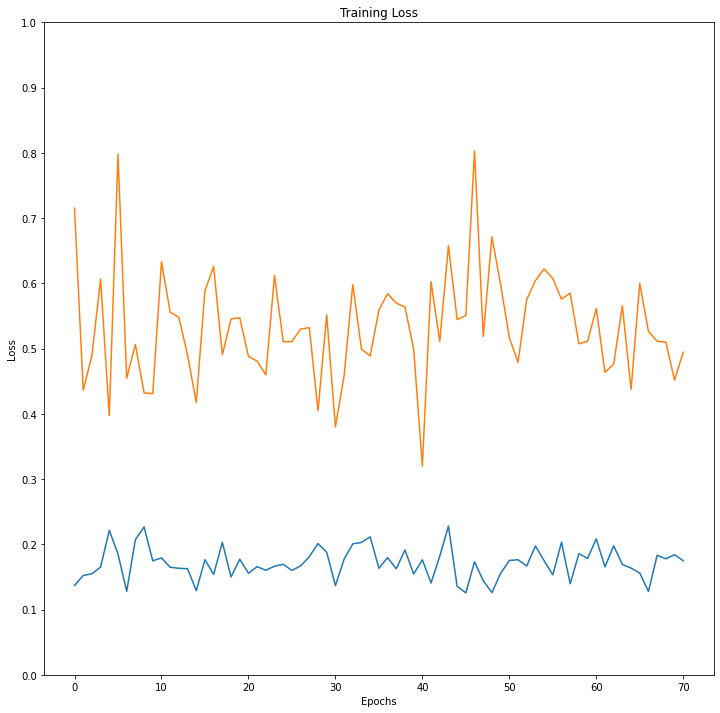

Epoch 71 		 Training Loss: 0.174801513671875 		 Validation Loss: 0.4945710060444284


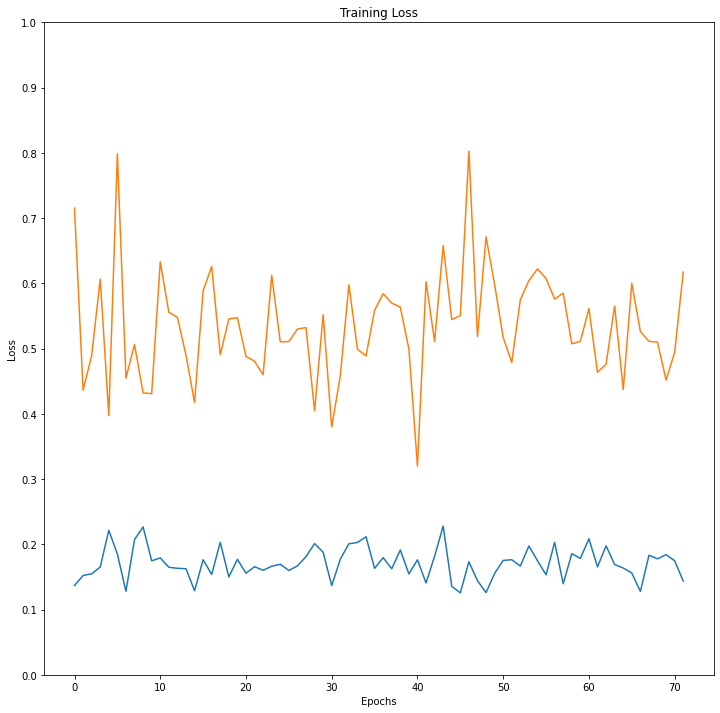

Epoch 72 		 Training Loss: 0.14369795735677082 		 Validation Loss: 0.6173503753986764


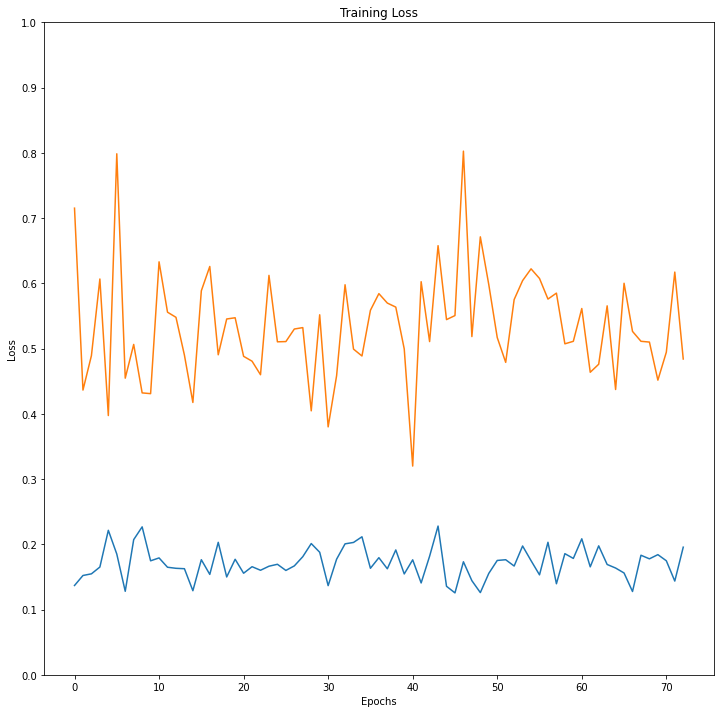

Epoch 73 		 Training Loss: 0.19564644368489584 		 Validation Loss: 0.4841002403421605


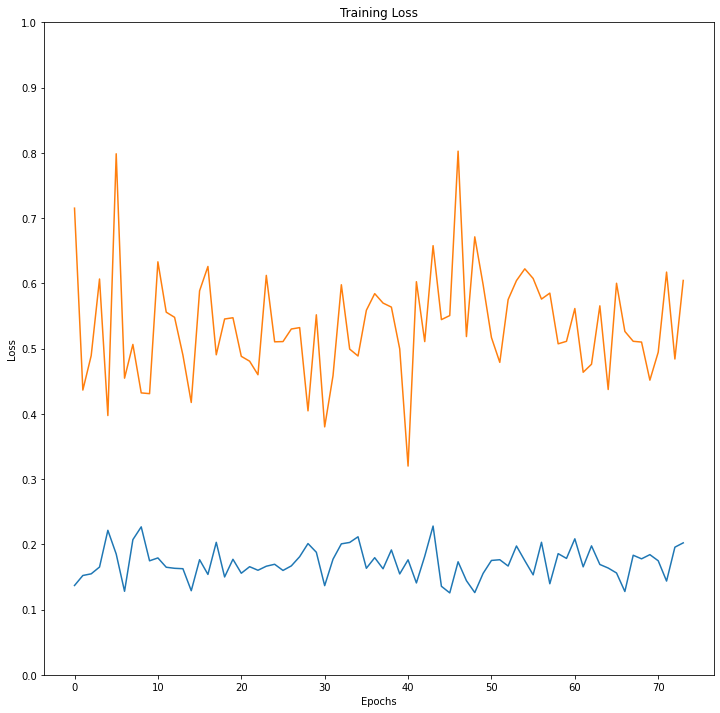

Epoch 74 		 Training Loss: 0.20226833089192708 		 Validation Loss: 0.6045238007890418


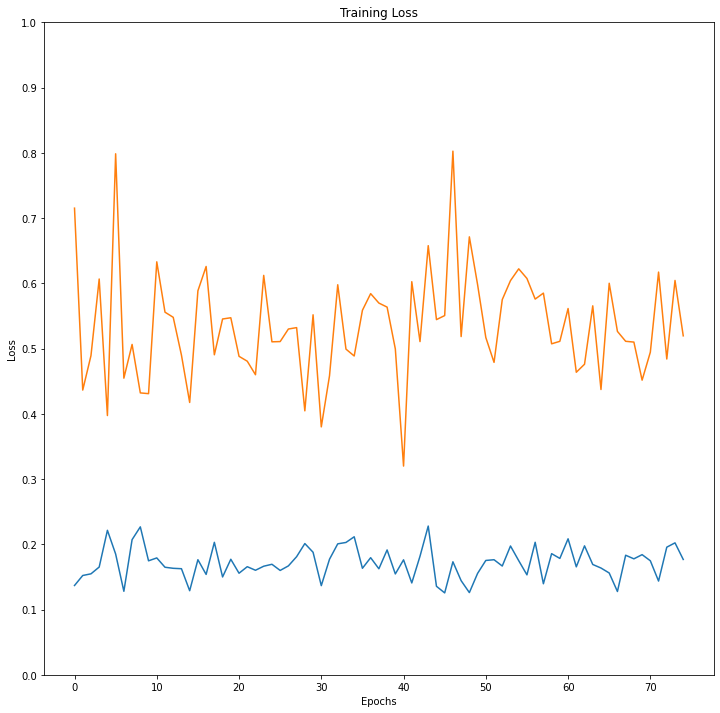

Epoch 75 		 Training Loss: 0.1768142293294271 		 Validation Loss: 0.5196432762957633


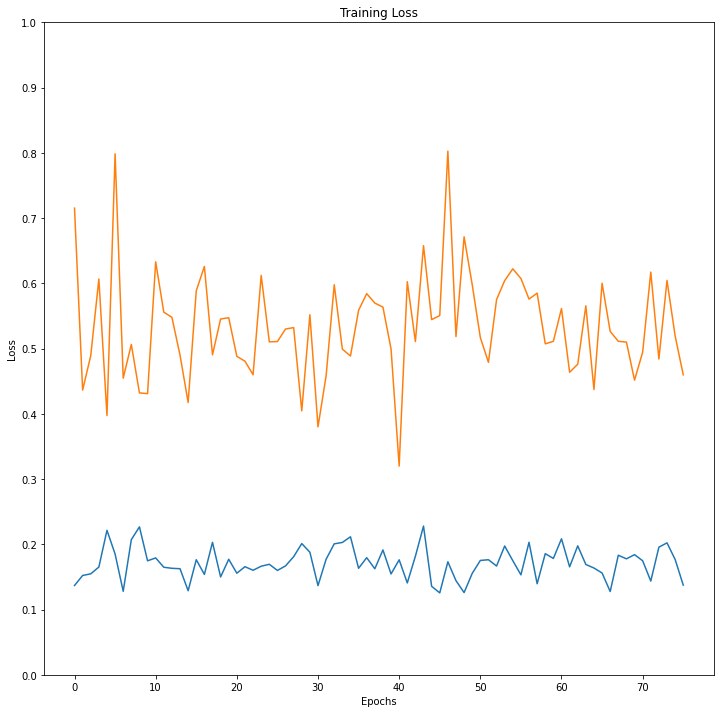

Epoch 76 		 Training Loss: 0.13753459676106772 		 Validation Loss: 0.45986290180936773


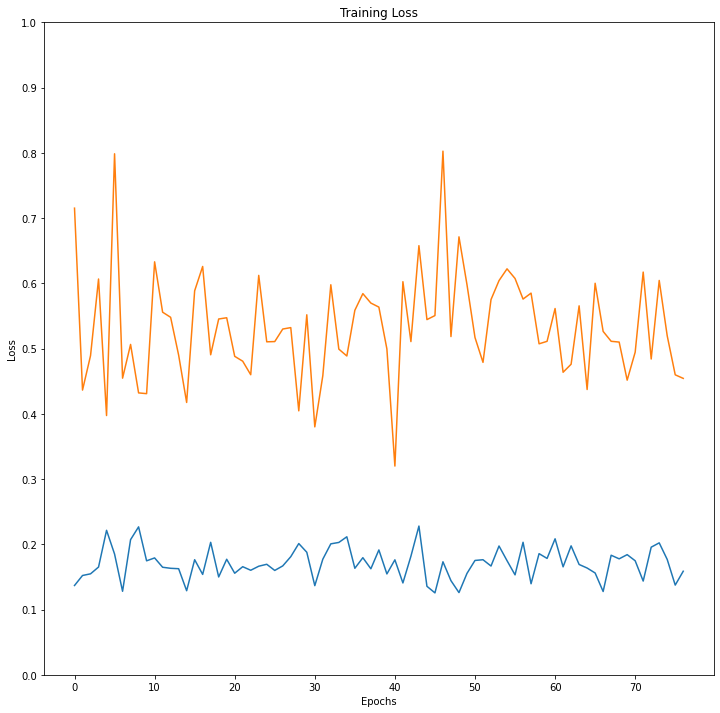

Epoch 77 		 Training Loss: 0.1587757568359375 		 Validation Loss: 0.45439874364974653


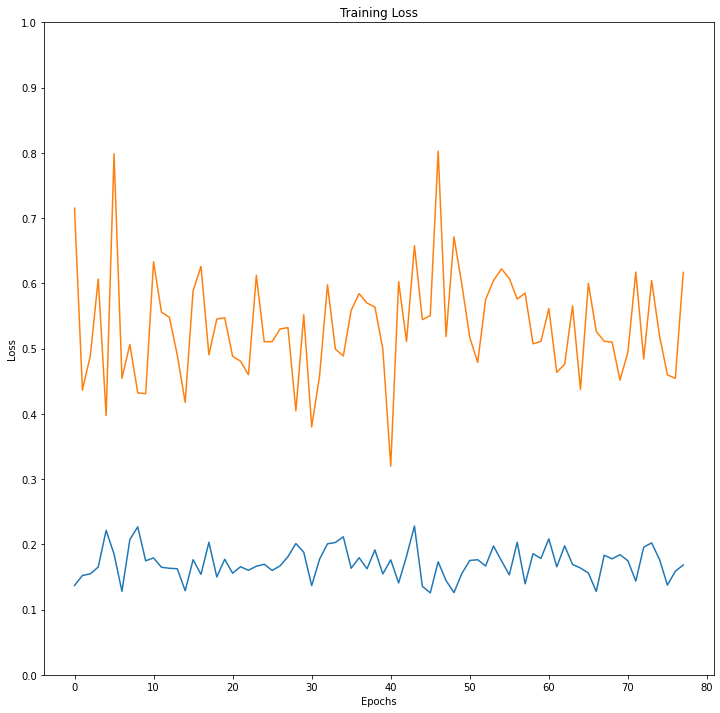

Epoch 78 		 Training Loss: 0.16837267049153645 		 Validation Loss: 0.6169168391126267


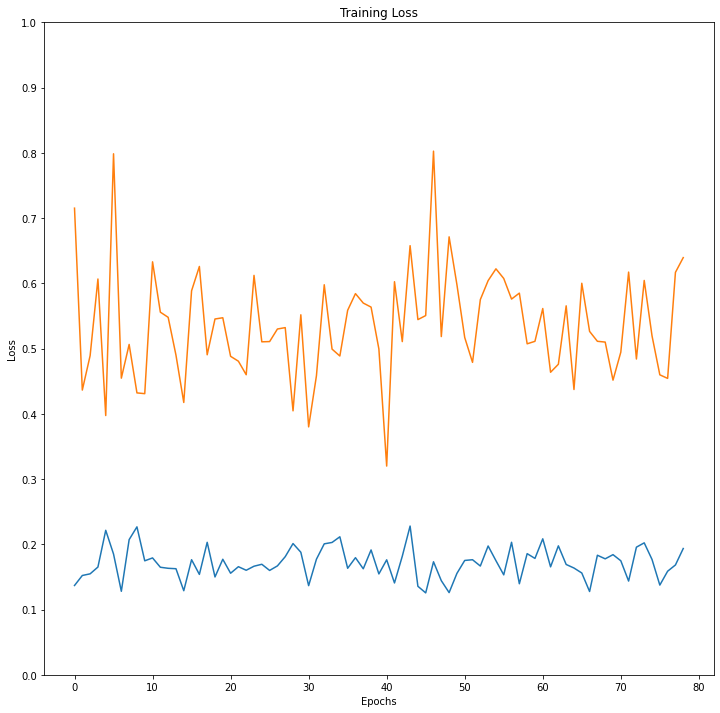

Epoch 79 		 Training Loss: 0.19359086100260417 		 Validation Loss: 0.639547530640947


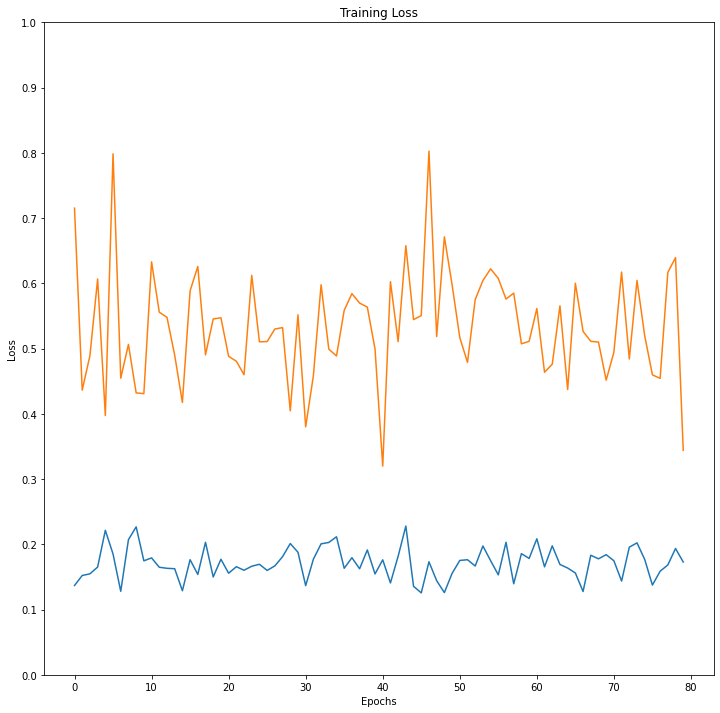

Epoch 80 		 Training Loss: 0.172892822265625 		 Validation Loss: 0.3440832685916982


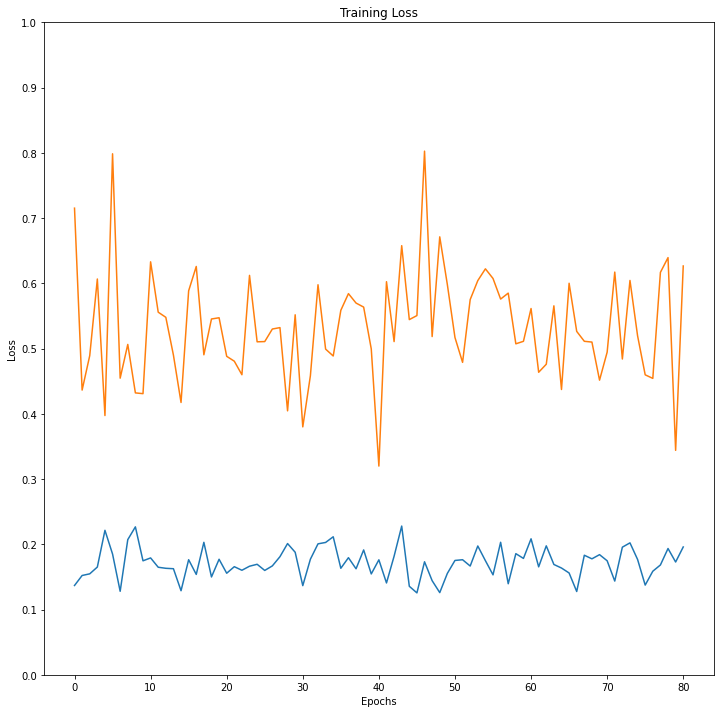

Epoch 81 		 Training Loss: 0.19597379557291666 		 Validation Loss: 0.6267090858297145


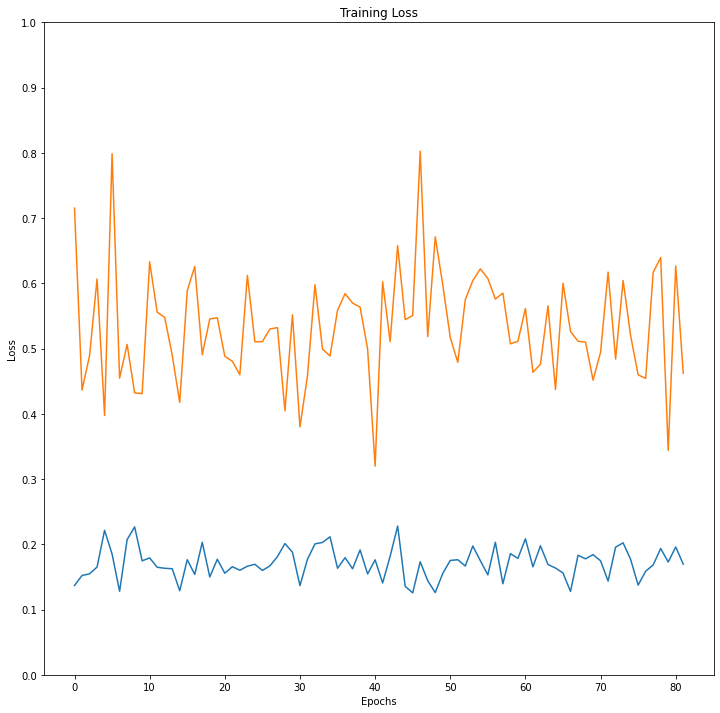

Epoch 82 		 Training Loss: 0.16965625 		 Validation Loss: 0.46216005974627555


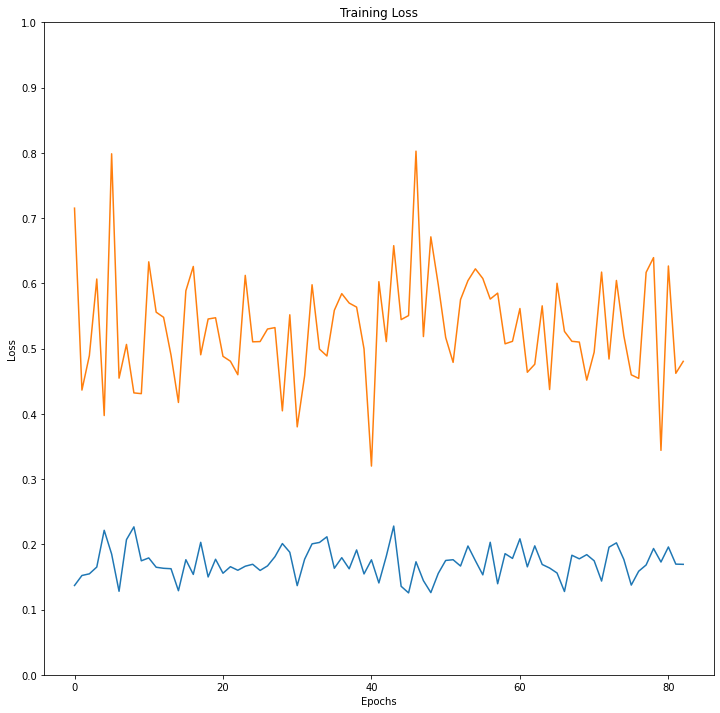

Epoch 83 		 Training Loss: 0.16934356689453126 		 Validation Loss: 0.4805203701587433


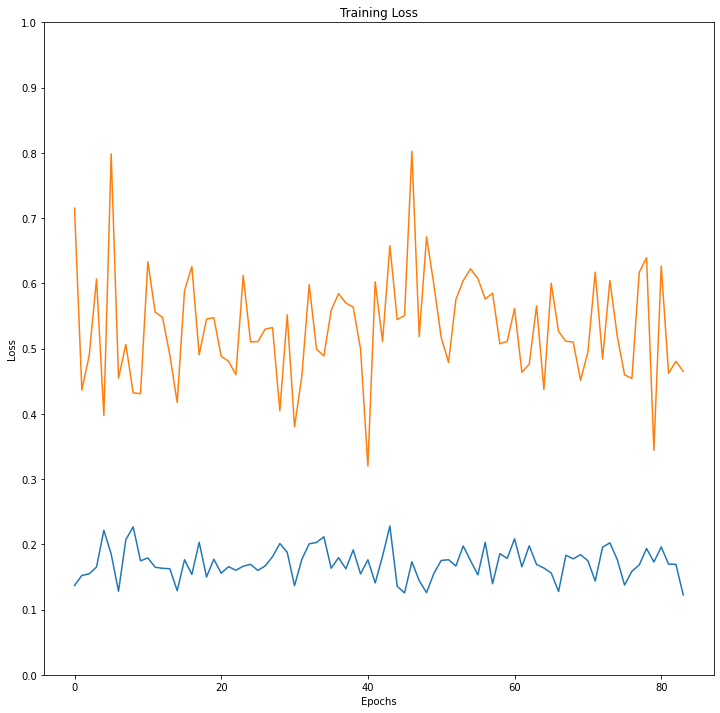

Epoch 84 		 Training Loss: 0.12247064208984375 		 Validation Loss: 0.4652402248788387


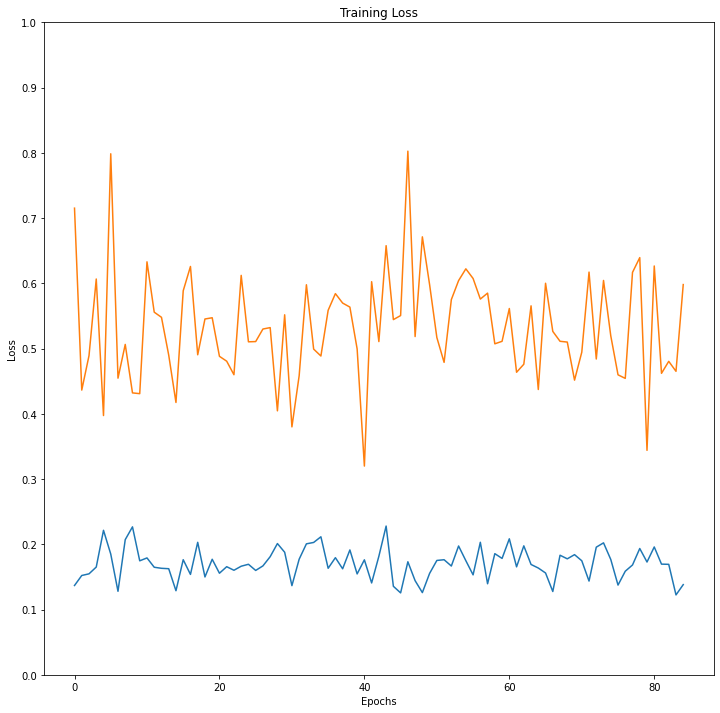

Epoch 85 		 Training Loss: 0.13823389689127605 		 Validation Loss: 0.5982190801742229


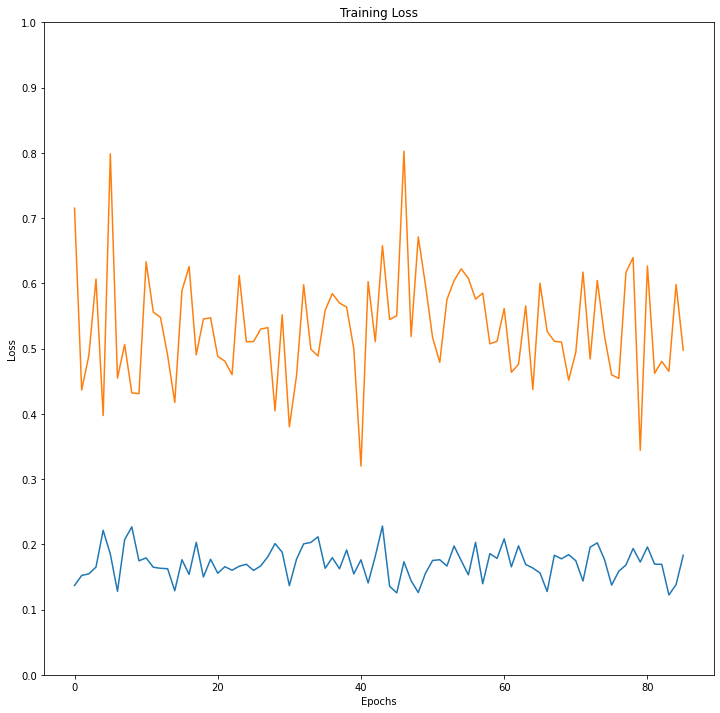

Epoch 86 		 Training Loss: 0.183310546875 		 Validation Loss: 0.49771043087573763


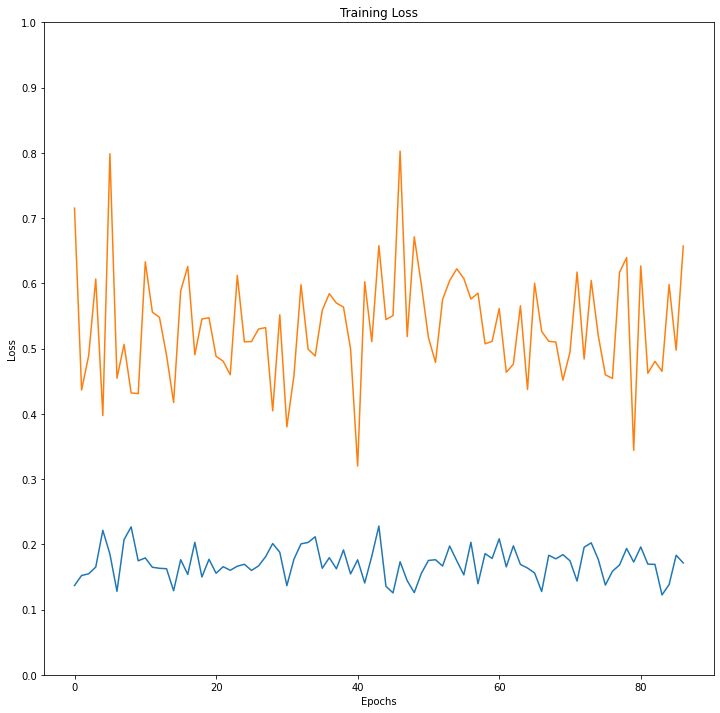

Epoch 87 		 Training Loss: 0.17147538248697916 		 Validation Loss: 0.6573366408652448


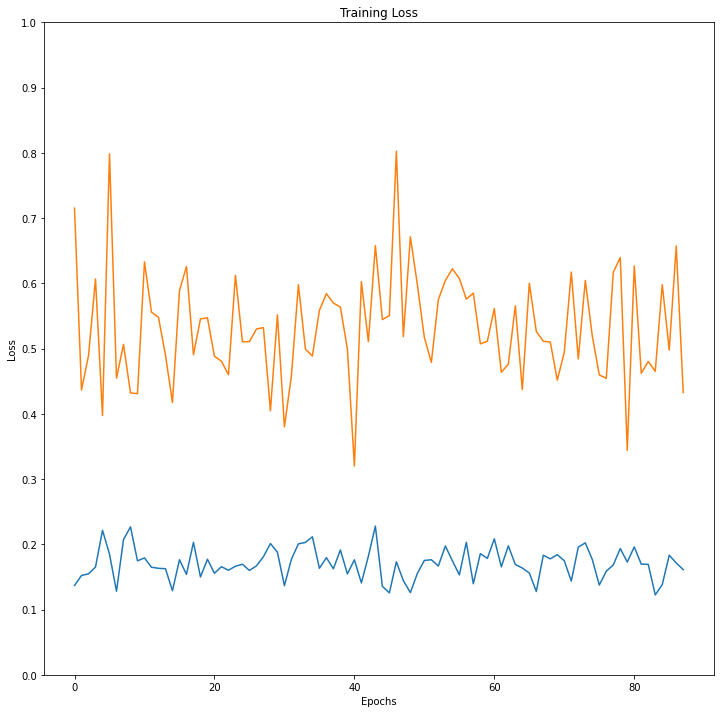

Epoch 88 		 Training Loss: 0.16118186442057292 		 Validation Loss: 0.43280060747836496


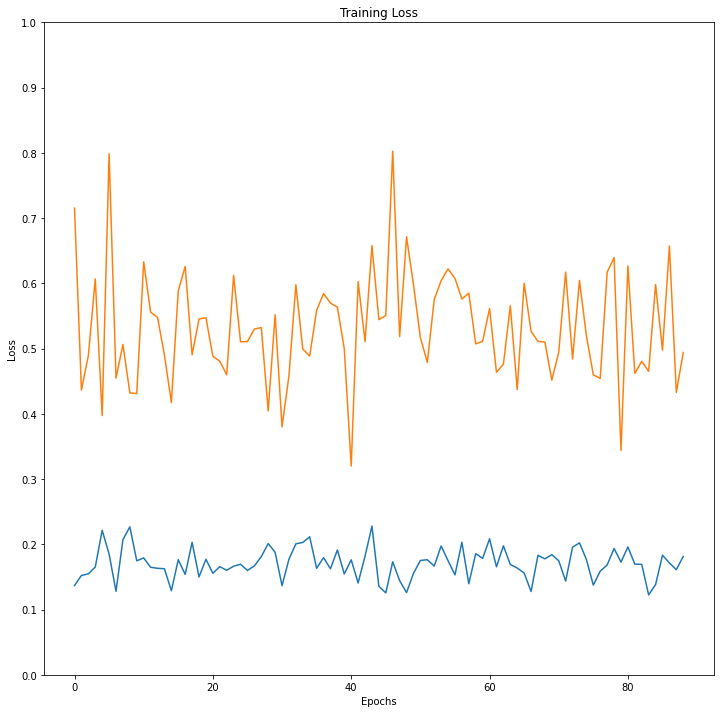

Epoch 89 		 Training Loss: 0.18144816080729168 		 Validation Loss: 0.4940481997550802


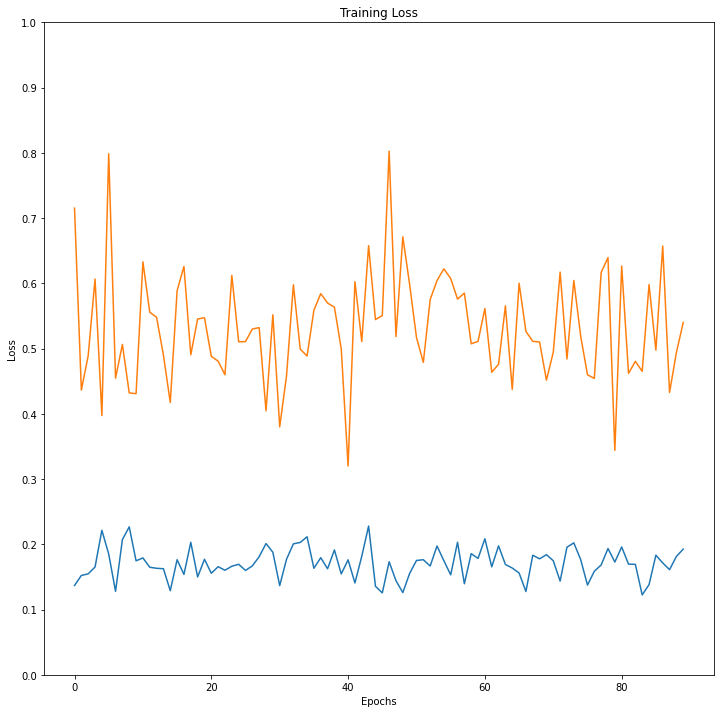

Epoch 90 		 Training Loss: 0.19269696044921875 		 Validation Loss: 0.5401654547833382


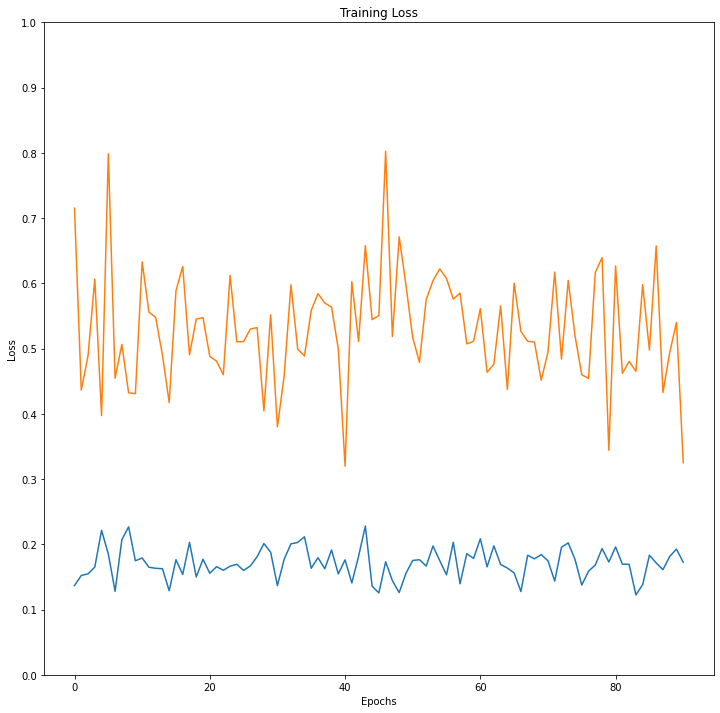

Epoch 91 		 Training Loss: 0.172343017578125 		 Validation Loss: 0.3251394616796615


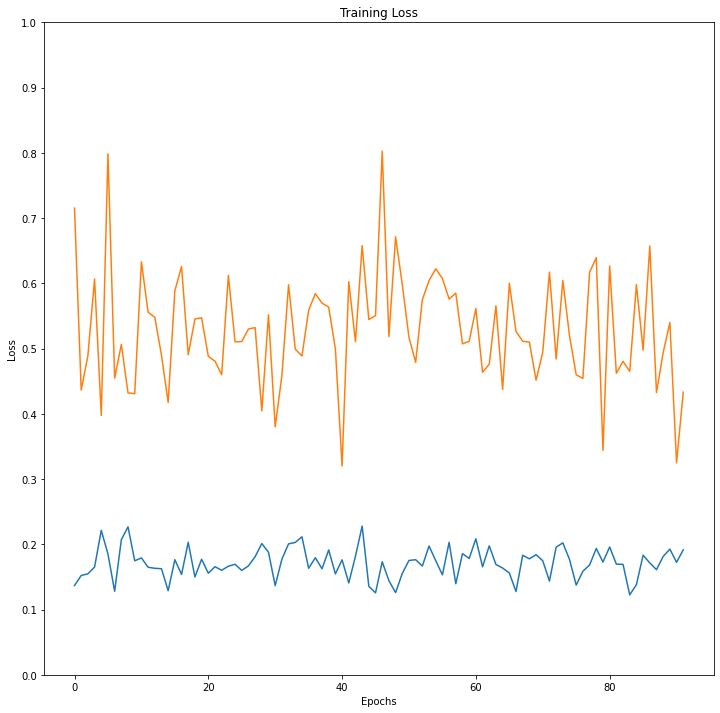

Epoch 92 		 Training Loss: 0.19161594645182292 		 Validation Loss: 0.4333220745654816


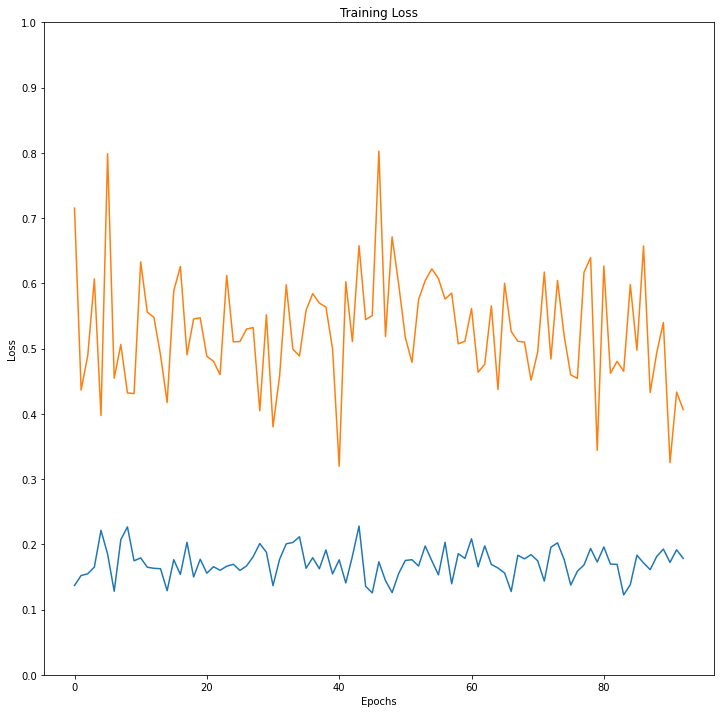

Epoch 93 		 Training Loss: 0.17835624186197915 		 Validation Loss: 0.4065788451661455


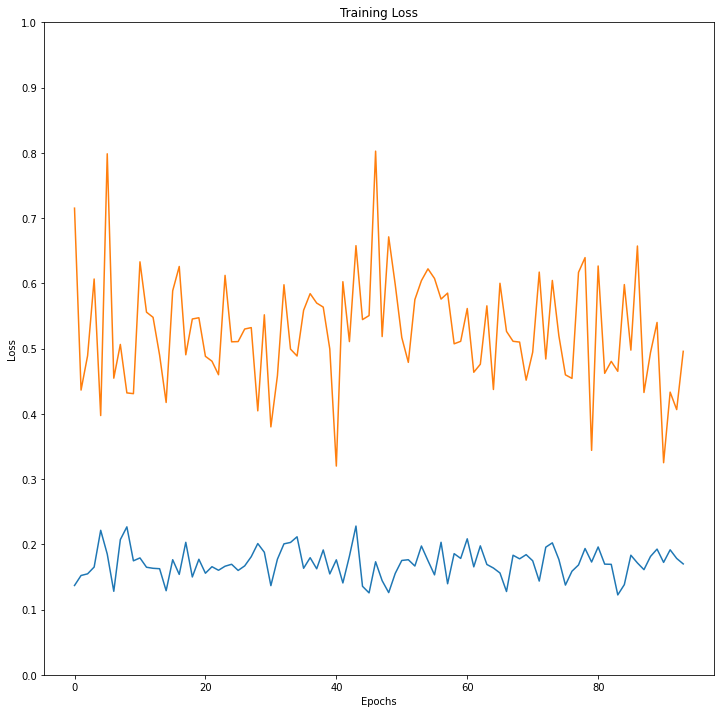

Epoch 94 		 Training Loss: 0.1699795939127604 		 Validation Loss: 0.4958743541798693


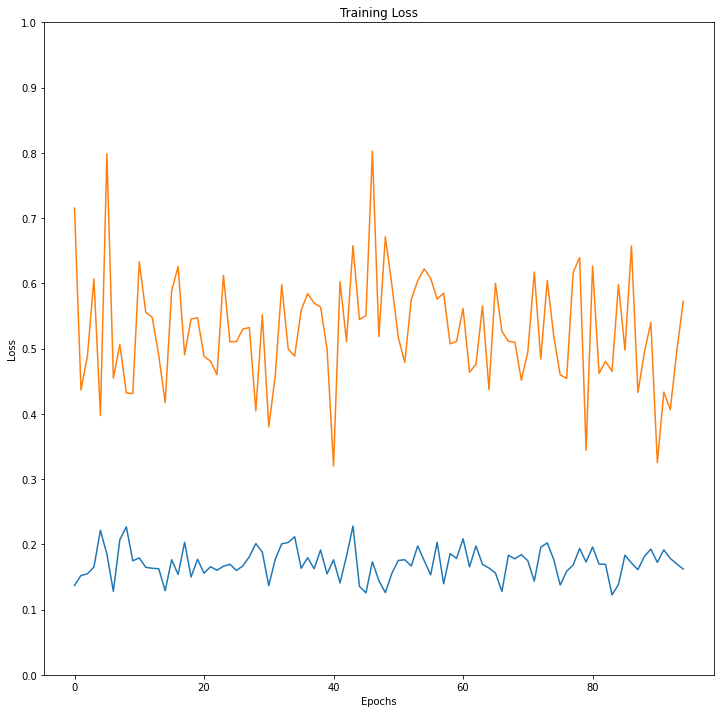

Epoch 95 		 Training Loss: 0.1620246785481771 		 Validation Loss: 0.5725701311801342


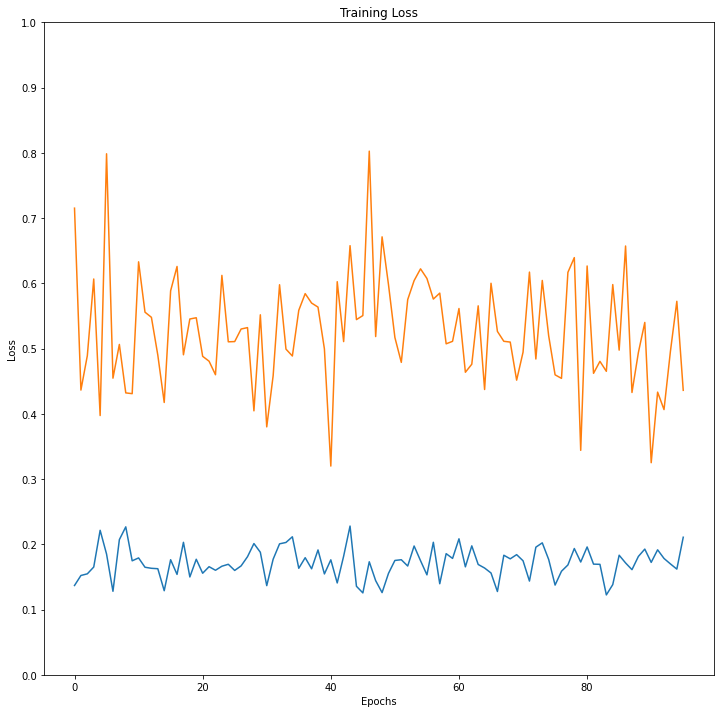

Epoch 96 		 Training Loss: 0.21089729817708333 		 Validation Loss: 0.43608536618821164


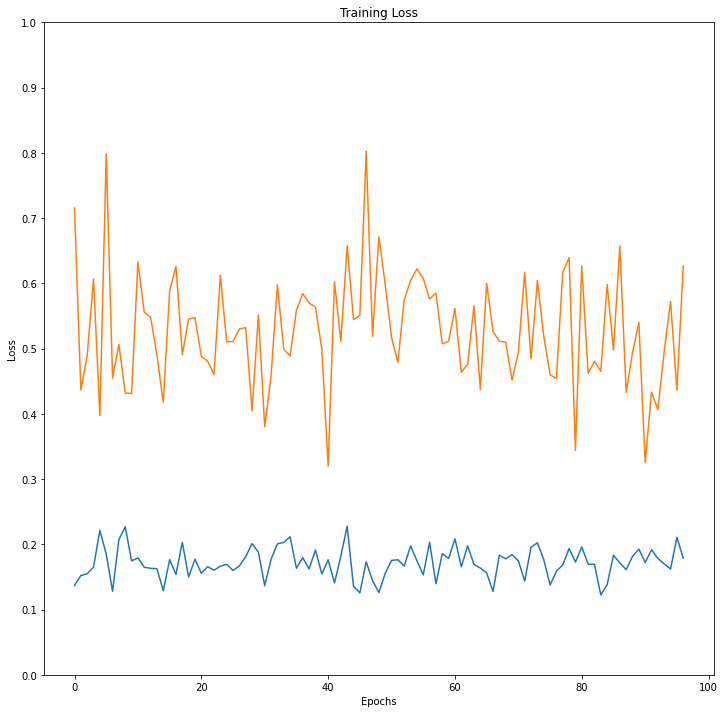

Epoch 97 		 Training Loss: 0.1786190185546875 		 Validation Loss: 0.6267494445151471


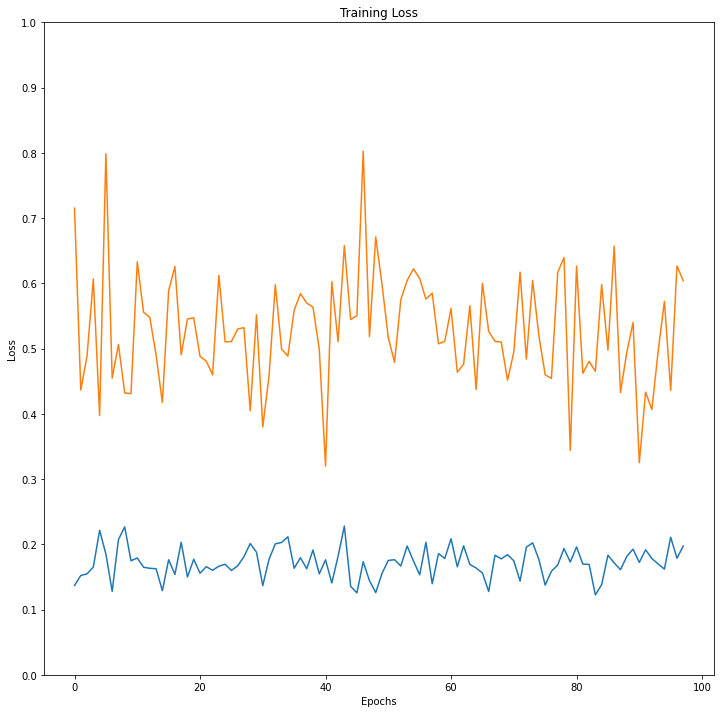

Epoch 98 		 Training Loss: 0.19741794840494792 		 Validation Loss: 0.6042494469500602


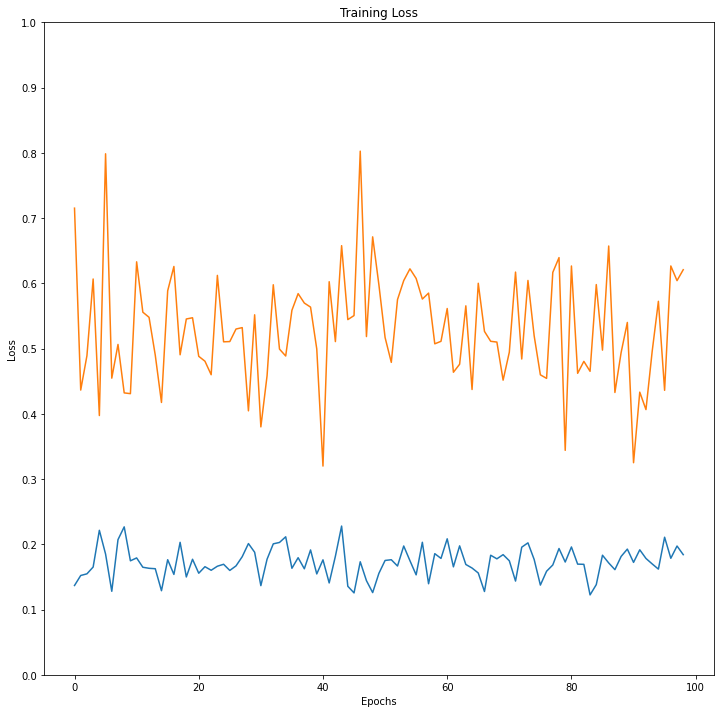

Epoch 99 		 Training Loss: 0.18419167073567708 		 Validation Loss: 0.6209983622774164


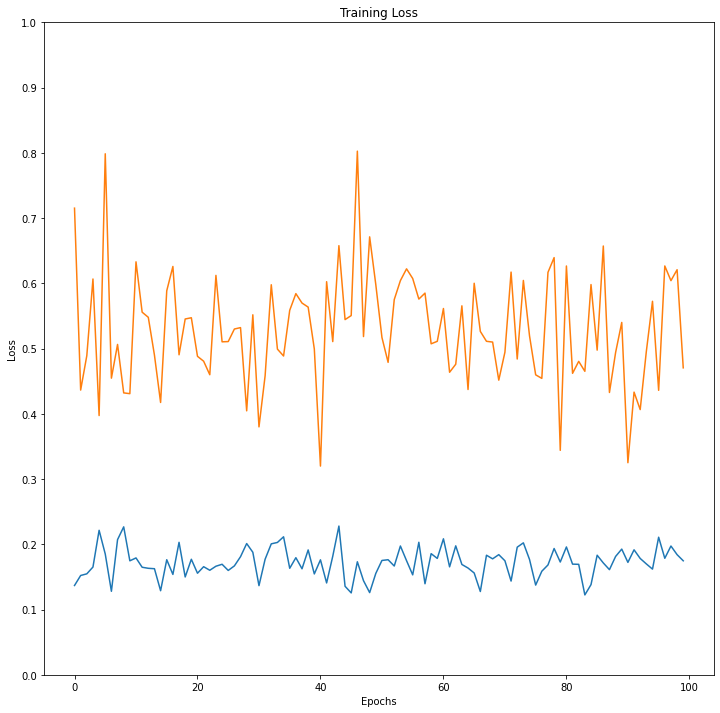

Epoch 100 		 Training Loss: 0.17475764973958333 		 Validation Loss: 0.4705808416325995


In [ ]:
loss_history = {'training': [], 'validation': []}
iteration_number= 0
epochs = 100
min_valid_loss = np.inf

for epoch in range(epochs):
  train_loss = 0.0
  for data in train_dataloader:
    # Grab images and label. Send them to GPU
    img_a, img_b, label = data
    img_a, img_b, label = img_a.cuda(), img_b.cuda(), label.cuda()

    # Clear the gradients
    optimizer.zero_grad()
    # Forward Pass the Images
    output_a, output_b = model(img_a,img_b)
    # Find the Loss
    loss = criterion(output_a, output_b, label)
    # Backprop
    loss.backward()
    # Update weights
    optimizer.step()
    # Calculate Loss
    train_loss = loss.item() * data[0].size(0)
  loss_history['training'].append(train_loss / len(train_dataloader))

  val_loss = 0.0
  model.eval()
  for data in val_dataloader:
    # Grab images and label. Send them to GPU
    img_a, img_b, label = data
    img_a, img_b, label = img_a.cuda(), img_b.cuda(), label.cuda()

    # Forward Pass the Images
    output_a, output_b = model(img_a,img_b)
    # Find the Loss
    loss = criterion(output_a, output_b, label)
    # Calculate Loss
    valid_loss = loss.item() * data[0].size(0)
  loss_history['validation'].append(valid_loss / len(val_dataloader))

  show_plot(epoch+1,loss_history)
  print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(val_dataloader)}')

  if min_valid_loss > valid_loss:
      print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
      min_valid_loss = valid_loss
        
      # Saving State Dict
      torch.save(model.state_dict(), 'saved_model.pth')

## Testing

In [ ]:
model.eval()
for data in test_dataloader:
  # Grab images and label. Send them to GPU
  img_a, img_b, label = data
  img_a, img_b, label = img_a.cuda(), img_b.cuda(), label.cuda()
  if img_a.size(0) == 12:
    output_a, output_b = model(img_a, img_b)
    print(output_a.size(), output_b.size(), label.size())
    test_loss = criterion(img_a, img_b, label) 
# print('test loss is {}'.format(test_loss))

torch.Size([24, 1]) torch.Size([24, 1]) torch.Size([12])
torch.Size([12, 1, 64, 64])


RuntimeError: ignored